<a href="https://colab.research.google.com/github/Andrea987/advtrain-linreg/blob/main/notebooks/fig1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
from re import VERBOSE
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import tqdm
import cvxpy as cp
print(cp.installed_solvers())
import numpy as np

import traceback


def compute_q(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, S_dict, p):  # S is the matrix such that ||S^(-1) @ Dx||\leq delta. As a consequence, S appears in the unconstrained problem
        # S: (n, n) matrix, or S = np.concatenate(tS), with tS = [S1,..,S_m], so S is (n * m, n)
        m, n = X.shape
        q = compute_q(p)
        #print("who is X", X)
        #print("who is y", y)
        #print("who is S", S)
        #print("who is q in AdversarialTraining: ", q)
        #Formulate problem
        param = cp.Variable(n)
        #print("shape param ", param.shape)
        #print("dim ", n)
        print("X ", m, n)
        #print("S_dict ", S_dict)
        #print("S in adv training", S)
        print("nm ", n*m)
        S_dts = S_dict['S_dts']
        S_mis = S_dict['S_mis']
        adv_radius_times_scale_dts = cp.Parameter(name='adv_radius_times_scale_dts', nonneg=True)
        adv_radius_times_scale_mis = cp.Parameter(name='adv_radius_times_scale_mis', nonneg=True)
        #scale_dts = cp.Parameter(name='scale_dts', nonneg=True)
        #scale_mis = cp.Parameter(name='scale_mis', nonneg=True)
        print("S_mis in Adbvt training ", S_mis)
        if np.sum(S_mis * S_mis) == 0:
          print("no missing part")
          S = S_dts * adv_radius_times_scale_dts
        elif S_mis.shape == (m, n, n):
          S_dts_tiled = np.concatenate([S_dts] * m)
          S_mis_conc = np.concatenate(S_mis)
          #np.concatenate([yyy] * 2)
          S = S_dts_tiled * adv_radius_times_scale_dts + S_mis_conc * adv_radius_times_scale_mis
          print("S type ", type(S))
          #S = np.concatenate(S)
          print("S is a tensor, concatenated")
          print("final S after conc \n", S)

        if S.shape == (n, n):
          print("one matrix in input, S.shape = (n, n)")
          partial = S @ param  # should be (m * n,)
          param_norm = cp.pnorm(partial, p=q)
        elif S.shape == (n * m, n):  # should be a stack of matrices
          print("multiple matrices in input, S conc")
          partial = S @ param  # should be (m * n,)
          partial = cp.reshape(partial, (m, n), order='C')
          param_norm = cp.pnorm(partial, p=q, axis=1)
        else:
          print("--------> ERROR: NO MATRIX S FOUND IN ADVERSARIAL TRAINING")
        #elif S.shape == (m , n):  # stack of diagonal matrices
        #  print("multiple matrices in input, S_i diag")
          #S_cvx = cp.Constant(S)
        #  partial = cp.multiply(cp.Parameter(S), param)
        #  param_norm = cp.pnorm(partial, p=q, axis=1)
        abs_error = cp.abs(X @ param - y)
        adv_loss = 1 / m * cp.sum((abs_error + param_norm) ** 2)
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius_times_scale_dts = adv_radius_times_scale_dts
        self.adv_radius_times_scale_mis = adv_radius_times_scale_mis
        #self.scale_dts = scale_dts
        #self.scale_mis = scale_mis
        self.param = param
        self.warm_start = False


    def __call__(self, dict_hyper_p, **kwargs):
        try:
            #print("dic thyper p ", dict_hyper_p)
            self.adv_radius_times_scale_dts.value = dict_hyper_p['adv_radius_times_scale_dts']
            self.adv_radius_times_scale_mis.value = dict_hyper_p['adv_radius_times_scale_mis']
            #self.scale_dts.value = dict_hyper_p['scale_dts
            #self.scale_mis.value = dict_hyper_p['scale_mis']
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v

'''
    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v
'''


def get_lasso_path(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []


def get_path(X, y, estimator, amax, dts_max, mis_max, eps_amax=1e-5, eps_dts_max=1e-3, eps_mis_max=1e-1, n_alphas=150, n_deltas_dts=5, n_deltas_mis=1):
    _, m = X.shape
    amin = eps_amax * amax
    dts_min = eps_dts_max * dts_max
    mis_min = eps_mis_max * mis_max
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    dts_deltas = np.logspace(np.log10(dts_min), np.log10(dts_max), n_deltas_dts)
    mis_deltas = np.logspace(np.log10(mis_min), np.log10(mis_max), n_deltas_mis)
    print("dts deltas ", dts_deltas)
    #hyper_p = {'scale_dts': dts_deltas, 'scale_mis': mis_deltas}
    hyper_p_ret_ = []
    coefs_ = []
    for scale_dts_value in tqdm.tqdm(dts_deltas):
        for scale_mis_value in tqdm.tqdm(mis_deltas):
          #tuple_key = (scale_dts_value, scale_mis_value)
          #coefs_ = []
          for a in tqdm.tqdm(alphas):
              #dict_hyper_p_values = {'adv_radius': a, 'scale_dts': scale_dts_value, 'scale_mis': scale_mis_value}
              dict_hyper_p_values = {'adv_radius_times_scale_dts': a * scale_dts_value, 'adv_radius_times_scale_mis': a * scale_mis_value}
              coefs = estimator(X, y, dict_hyper_p_values)
              #print("alpha  ", a, "coef: ", coefs)
              coefs_.append(coefs if coefs is not None else np.zeros(m))
              hyper_p_ret_.append([a, scale_dts_value, scale_mis_value])
          #res[tuple_key] = np.stack((coefs_)).T
    return np.stack((hyper_p_ret_)).T, np.stack((coefs_)).T

'''
def get_path(X, y, estimator, amax, eps=1e-5, n_alphas=200):
    _, m = X.shape
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        coefs = estimator(X, y, a)
        #print("alpha  ", a, "coef: ", coefs)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T
'''


def plot_coefs(alphas, coefs, ax):
    #print("you are printing coefs in function of 1/alphas")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).sum(axis=0)
    ax.set_xlabel("1/alphas")
    ax.set_ylabel("coef")
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)
        #ax.semilogx(1/alphas, l1norm, c=c)
        #ax.plot(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    #print("you are printing coeff in function of l1 norm")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).mean(axis=0)
    l1norm = np.abs(coefs).sum(axis=0)
    #print("coef ", coefs)
    #print("l1norm ", l1norm)
    ax.set_xlabel("l1norm")
    ax.set_ylabel("coef")


    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)


def train_and_plot(X, y, S_dict, list_ax):
    linfadvtrain = AdversarialTraining(X, y, S_dict, p=np.inf)
    estimator = lambda X, y, dic_h:  linfadvtrain(dict_hyper_p=dic_h)
    hyper_p, coefs_advtrain_linf  = get_path(X, y, estimator, 1e3, 1e-1, 1e0)
    #print("hyper_p used\n ", hyper_p)
    if len(list_ax) > 0:
      plot_coefs_l1norm(coefs_advtrain_linf, list_ax[0])
      plot_coefs(alphas_adv, coefs_advtrain_linf, list_ax[1])
    return hyper_p, coefs_advtrain_linf

'''
def add_rectangles_old(x, y, box_width, box_height, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)

  for xi, yi in zip(x[r_c], y[r_c]):
      rect = patches.Rectangle(
        (xi-box_width/2, yi-box_height/2),
        box_width, box_height,
        linewidth=1, edgecolor='r', facecolor='none'
      )
      ax.add_patch(rect)
'''

def add_rectangles(x, y, S, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)
  d = S.shape[-1]
  #S = S * 100
  if S.ndim == 2 or S.shape == (1, d, d):
    S = S.squeeze()
    print("------------------------> who is S in add_rectangles\n", S)
    box_width = S[0, 0]
    box_height = S[1, 1]
    for xi, yi in zip(x[r_c], y[r_c]):
        rect = patches.Rectangle(
          (xi-box_width/2, yi-box_height/2),
          box_width, box_height,
          linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
  else:  # S is something like (n, d, d)
    #print("---------------> who is S in add_rectangles (mult imp)\n", S)
    box_width = S[:, 0, 0]
    box_height = S[:, 1, 1]
    #print("bw\n ", box_width)
    #print("bh\n ", box_height)
    #print("------------------------------> boxes printed")
    for xi, yi, bw, bh in zip(x[r_c], y[r_c], box_width[r_c], box_height[r_c]):
        #print("bw, bh ", bw, ",   ", bh)
        rect = patches.Rectangle(
          (xi-bw/2, yi-bh/2),
          bw, bh, linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
    ax.set_aspect('equal')



print("end block")


['CLARABEL', 'CVXOPT', 'GLPK', 'GLPK_MI', 'HIGHS', 'OSQP', 'SCIPY', 'SCS']
end block


In [3]:
# imputation's block

def clear_dataset(X, y, masks):
  # remove observations full NaN
  # X is an (n, d) matrix, y is a (n,) vector,
  # masks is an (n, d) binary matrix associated to X. 1 missing, 0 seen
  M = np.sum(1 - masks, axis=1) > 0
  M_col = np.sum(1 - masks, axis=0) > 0  # True if in the column there is at least one seen component
  if np.sum(M_col) < masks.shape[1]:
    print("Careful, there is one column full of nan")
  return X[M, :][:, M_col], y[M], masks[M, :][:, M_col]


def single_imputation(X_nan, impute_estimator):
    ice = IterativeImputer(estimator=impute_estimator)
    return ice.fit_transform(X_nan)


def multiple_imputation(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


def imputation_elliptic(mu, sigma, x, masks):
  # mu, mean elliptical distribution (,d)
  # sigma, cov matrix elliptical distribution (d, d)
  # x: dataset (n, d)
  # masks: mask data, 0 seen, 1 missing
  n, d = x.shape
  print(n, d)
  x_imp = x.copy()
  #print("x_imp clean", x_imp)
  for i in range(n):
    if not (masks[i, :] == 0).all():  # if we have at least one missing component
      #print("nbr : ", i)
      x_c = x[i, :]
      m_bool = (masks[i, :] == 0)  # True seen, False missing
      sigma_aa_inv = np.linalg.inv(sigma[m_bool, :][:, m_bool])
      sigma_ma = sigma[~m_bool, :][:, m_bool]
      mu_cond = mu[~m_bool] + sigma_ma @ sigma_aa_inv @ (x_c[m_bool] - mu[m_bool])
      x_imp[i, ~m_bool] = mu_cond
  return x_imp


def listwise_delection(X, masks):
  # masks: 1 missing, 0 seen
    M = np.sum(masks, axis=1) == 0  # zeros components are the one with full entries
    ret = X[M, :] if X.ndim == 2 else X[M]
    return ret


In [4]:
#np.random.seed(42)

#p_miss_2d = [0.2, 0.4, 0.4]
#beta_2d = np.array([0.5, 2])  # ground truth

from sklearn.datasets import make_moons, make_circles
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split

def generate_masks_2d(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks

def best_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  score = np.mean(r * r, axis=1)
  print("scores:  ", score)
  i_min = np.argmin(score)
  return coeff[:, i_min], score[i_min]

def best_idx_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  #score = np.mean(r * r, axis=1)
  score = np.mean(r * r, axis=1)
  #print("score in best idx", score)
  i_min = np.argmin(score)
  #### find the minimum value with a threshold, so we get bigger uncertainty set that are visible
  min = np.min(score)
  max = np.max(score)
  score[ score < min + 1e-2 ] = max
  ####
  #print("score after ", score)
  i_min = np.argmin(score)
  return i_min, score[i_min]



def generate_X(data, dim):
    if data == 'Gaussian':
      def generator(n):
        return np.random.randn(n, dim)
    elif data == 'Uniform':
      def generator(n):
        return np.random.rand(n, dim)
    elif data == 'moons':
      def generator(n):
        return make_moons(n, noise=0.1)[0]
    elif data == 'circles':
      def generator(n):
        return make_circles(n, noise=0.1, factor=0.4)[0]
    return generator


In [5]:
# experiment 2d with dataset generated externally

def imputations(info, dict_obs_for_imp):  # X_nan, y):
  # info contains the method and possible extra information
  # X_nan is the dataset with nan in place of the missing components
  # y is return as it is, unless the method require to change it, like in
  # listwise deletion
    #print(info)
    X_nan = dict_obs_for_imp['X_nan']
    y = dict_obs_for_imp['y_train']
    mask_from_X_nan = np.isnan(X_nan).astype(int)
    if info['imp_method'] == 'BR_si':  # Baeysian_Ridge_single_imputation
        X = single_imputation(X_nan, BayesianRidge())
    elif info['imp_method'] in  ['mi', 'mi_pure']:
        X = multiple_imputation(info['mi_nbr'], X_nan)
    elif info['imp_method'] == 'l_d':  # listwise_deletion
        #mask_from_X_nan = np.isnan(X_nan).astype(int)
        X = listwise_delection(X_nan, mask_from_X_nan)
        y = listwise_delection(y, mask_from_X_nan)
        if len(X) == 0:  # no elements left, add an artificial element
            X = np.zeros((1, X_nan.shape[-1]))
            y = np.zeros(1)
        mask_from_X_nan = np.zeros_like(X)
    elif info['imp_method'] == 'oracle':
        X = dict_obs_for_imp['X_train_masked'][0]
        mask_from_X_nan = np.zeros_like(X)
    else:
      print("-------------------> ERROR: WRONG KEYWORD (in imputations)")
    return X, y, mask_from_X_nan


def cov_strategy(info, dict_observations):
    X_imputed = dict_observations['X_imputed']
    X_nan = dict_observations['X_nan']
    masks = dict_observations['masks_after_imputation']
    print(np.sum(masks, axis=-1))
    if info['cov_strategy'] == 'sd':
      sd = np.std(X_imputed, axis=0)
      #print("sd in cov strategy ", sd)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'inv_sd':
      sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(1 / sd)
    elif info['cov_strategy'] == 'zero':
      #sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.zeros((X_imputed.shape[-1], X_imputed.shape[-1]))
    elif info['cov_strategy'] == 'eye':
      S = np.eye(X_imputed.shape[-1])
    elif info['cov_strategy'] == 'threshold':
      sd = np.std(X_imputed, axis=0)
      sd[sd < info['threshold']] = info['threshold']
      #S = np.diag(sd) The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'std_nan':
      if info['imp_method'] in ['oracle']:
        print("DON'T USE std_nan with oracle and ld because you do not have any nan. Use sd")
      else:
        std_columnwise = np.nanstd(X_nan, axis=0)
        S = np.diag(std_columnwise)
    elif info['imp_method'] in ['mi_pure', 'mi']:  # Rubin's Rule
      if info['cov_strategy'] == 'std_mi':
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        S = np.diag(s_within)
        print("final S in cov strategy std_mi ", S)
      elif info['cov_strategy'] == 'RR':
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d. That's already scaled because we are computing the std
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        print("final S in cov strategy RR ", S)
        #mu = np.mean(X_imputed, axis=0)
        #sigma = np.cov(X_imputed, rowvar=False)
      elif info['cov_strategy'] == 'RR_scaled (to check)':
        print("Rub Rule right scaled")
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2) # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d
        #s_between = np.sqrt(s_between)
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        #S = np.sqrt(S)
        print("final S in cov strategy RR ", S)
      #elif info['cov_strategy'] == 'cond_var':
        # we have imputed [X1,..,X_m]
        #s = np.std(X_imputed, axis=0)
        #print("s\n ", s)
        #eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        #S = eye * s[:, None, :]
        #S = np.concatenate(S, axis=0)
        #print("S in cond variance ", S)
    elif info['cov_strategy'] == 'lounici':
      mu = np.nanmean(X_nan, axis=0)
      print("means ", mu)
      delta = 1 - np.mean(masks) # parameter missingness
      print("delta ", delta)
      X_0 = np.nan_to_num(X_nan - mu)  # check if this is correct
      print("nbr obs", X_0.shape[0])
      S =  X_0.T @ X_0 / X_0.shape[0]
      S = (1/delta - 1/(delta**2)) * np.diag(np.diag(S)) + 1/(delta**2) * S
    else:
      raise ValueError("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #print("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #S = np.diag(S)
      #mu = np.mean(X_imputed, axis=0)
      #sigma = np.cov(X_imputed, rowvar=False)
    return S


def cov_strategy_missing(info, dict_observations):
    # undertainty that come from the imputed part. It is zero
    X_imputed = dict_observations['X_imputed']
    if info['imp_method'] in ['mi', 'mi_pure']:
      if info['cov_strategy_between'] == 'cond_var':
        # we have imputed [X1,..,X_m], so shape (m, n, d)
        s = np.std(X_imputed, axis=0)
        s[s<1e-14] = 0  # set to zero values that are basically zero
        #print("var ", s)
        eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        S_mis = eye * s[:, None, :]
    else:
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape[-1])
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape)
      d = dict_observations['X_test'].shape[-1]
      S_mis = np.zeros((d, d))
    return S_mis


def post_imputation(info_imp, dict_dataset):
  # X_imptued should be a matrix (n, d) or tensor (m, d, n) (in multiple imputations methods)
    X_imputed = dict_dataset['X_imputed']
    y_train = dict_dataset['y_from_X_imputed']
    #print("info imp in post_imp", info_imp)
    print("shape X_imputed in post_imputation ", X_imputed.shape)
    mask_train = dict_dataset['masks_after_imputation']
    if 'post_imp' not in info_imp.keys():
      X_train = X_imputed
    elif info_imp['post_imp'] == 'mean':
      #print("entered in pst_iputation, in mi_mean")
      X_train = np.mean(X_imputed, axis=0)
    elif info_imp['post_imp'] == 'conc':
      X_train = np.concatenate(X_imputed)
    else:
      X_train = X_imputed
    return X_train, y_train, mask_train


def generate_dataset(data, n_tot, dim, beta_gt, perc_test, p_miss, err):
    print(data)
    if data['data'] == 'Gaussian':
      X_complete = np.random.randn(n_tot, dim)
    elif data['data'] == 'Normal':
      #print("you are here")
      X_complete = np.random.multivariate_normal(mean=data['mean'], cov=data['cov'], size=n_tot)
    elif data['data'] == 'Uniform':
      X_complete = np.random.rand(n_tot, dim)
    elif data['data'] == 'moons':
      X_complete = make_moons(n_tot, noise=0.1)[0]
    elif data['data'] == 'circles':
      X_complete = make_circles(n_tot, noise=0.1, factor=0.4)[0]

    if err['type'] == 'Gaussian_on_y':
      #print("---> you have entered in GAUSSIAN ERROR ", "scaling : ", err['scaling'])
      error = np.random.randn(n_tot) * err['scaling']
    elif err['type'] == 'Uniform_on_y':
      error = (np.random.rand(n_tot)-0.5) * err['scaling']
    elif err['type'] == 'Gaussian_on_X':
      error = (np.random.randn(n_tot, dim) @ beta_gt) * err['scaling']  # error is of the form DX@beta_gt + error
    #elif err['type'] == 'Gaussian':
    #  error = np.random.randn(n_tot) * err['scaling']

    print(X_complete.shape)

    y_complete = X_complete @ beta_gt + error  #np.random.randn(n_tot) * err  # (np.random.rand(n_tot) - 0.5) * err
    X_train, X_test, y_train, y_test = train_test_split(X_complete, y_complete, test_size=perc_test)
    n_train = X_train.shape[0]
    masks_train = generate_masks_2d(n_train, p_miss)  # 1 missing, 0 observed
    #M = np.sum(masks, axis=1)  # M[i] > 0 iff i has missing component
    #dict_obs = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test, 'masks_train': masks_train}
    dict_obs = {'X_train_masked': (X_train, masks_train), 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}#, 'masks_train': masks_train}
    return dict_obs


def experiment_2d_ext_dataset(dict_obs, dict_imp, ax):
    # dict_obs contains info on the observations, i.e. train, test, masks
    # dict_imp contains info on the imputation an covariance methods used,
    # dict_imp = {'imp_method': , 'cov_strategy': , .... }
    # ax contains info for the plots

    X_test = dict_obs['X_test']
    y_test = dict_obs['y_test']
    mask = dict_obs['X_train_masked'][1]

    M = np.sum(mask, axis=1)  # M[i] > 0 iff i has missing component

    X_nan_train = dict_obs['X_train_masked'][0].copy()
    oracle_sd = np.std(X_nan_train, axis=0)
    print("-------> ORACLE SD, std of the original dataset (with no missing)", oracle_sd)
    X_nan_train[mask == 1] = np.nan
    #print("dict imp -----> ", dict_imp)
    dict_obs = dict_obs | {'X_nan': X_nan_train} #, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    if len(dict_obs['imp_ds'][dict_imp['imp_method']]) == 0:  # no previous imputation has been done
      #results = imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      results = imputations(dict_imp, dict_obs)
      X_imputed, y_from_X_imputed, mask_from_X_imputed = results  # imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      dict_obs['imp_ds'][dict_imp['imp_method']].append(results)
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    else:
      X_imputed, y_from_X_imputed, mask_from_X_imputed = dict_obs['imp_ds'][dict_imp['imp_method']][0]
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    #print("X_imputed ", X_imputed)
    n_imputed, n_test = X_imputed.shape[-2], X_test.shape[-2]
    #print("X_train\n ", X_train)
    M = np.sum(mask_from_X_imputed, axis=1)  # M[i] > 0 iff i has missing component

    dict_obs = dict_obs | {'X_imputed': X_imputed, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    #  print(dict_obs)
    S_dataset = cov_strategy(dict_imp, dict_obs) * dict_imp['multip_dataset']
    print("S dataset \n", S_dataset)
    #  dict_obs = dict_obs | {'cov_within': S_within}
    S_missing = cov_strategy_missing(dict_imp, dict_obs)  * dict_imp['multip_missing']
    print("S missing shape\n ", S_missing.shape)
    print("S missing\n ", S_missing)
    #  dict_obs = dict_obs | {'cov_between': S_between}
    S_dict = {'S_dts': S_dataset, 'S_mis': S_missing}  #, 'multipliers_dts': dict_imp['multip_dataset'], 'multipliers_mis': dict_imp['multip_missing']}
    #if True:  # check what to do of this part later
      #S = S_dataset * dict_imp['multip_dataset'] + S_missing * dict_imp['multip_missing']
      #if S.ndim == 2:
      #  print("final S \n", S)


    #print("matrices S \n", S)
    #print("---....---....----....--> diag matrix: ", np.diag(S))

    #if dict_imp['imp_method'] == 'mi':  # prepare the training set in case of multiple imputation
    #  X_train = np.concatenate(X_train)  # X_train, if the method is mi, should be (mi_nbr, n, dim)
    #  y_train = np.tile(y_train, reps=dict_imp['mi_nbr'])
    #  mask_train = np.tile(mask_train, reps=(dict_imp['mi_nbr'], 1))
    #  M = np.sum(mask_train, axis=1)
    #print("final matrices (exp 2d ext run)\n ", S)
    X_train, y_train, mask_train = post_imputation(dict_imp, dict_obs)
    n_train = X_train.shape[-2]
    print("y_train length ", y_train.shape[0])
    print("-------> size test: ", n_test, " , size train: ", n_train, "nbr_seen (train): ", np.sum(M == 0), " nbr_miss : ", np.sum(M > 0))

#    plt.tight_layout()
    #S_between = S.copy()
    if dict_imp['imp_method'] == 'mi_pure':
      best_coeff = np.zeros(X_train.shape[-1])
      best_alpha = 0
      for i in range(dict_imp['mi_nbr']):
        print("i .-------------> ", i)
        dict_obs_i = {'X_imputed': X_train[i, :, :], 'X_nan': X_nan_train, 'masks': mask_train}
        dict_imp_new = {'imp_method': dict_imp['imp_method'], 'cov_strategy': dict_imp['cov_strategy_within']}
        S_within = cov_strategy(dict_imp_new, dict_obs_i)  # within the dataset
        #print("S_within ", S_within)
        S = S_within[None, :, :] + S_between
        S = np.concatenate(S, axis=0)
        #print(S)
        alphas_used, coeff_results = train_and_plot(X_train[i, :, :], y_train, S, [ax[1], ax[2]])
        idx_best, min_score = best_idx_predictor(X_test, coeff_results, y_test)
        best_coeff_partial, best_alpha_partial = coeff_results[:, idx_best], alphas_used[idx_best]
        print("best coeff partial ", best_coeff_partial)
        best_coeff += best_coeff_partial
        best_alpha += best_alpha_partial
        if len(ax) > 0:
          ax[0].scatter(X_train[i, M == 0, 0], X_train[i, M == 0, 1])
          ax[0].scatter(X_train[i, M == 1, 0], X_train[i, M == 1, 1])
          ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
          add_rectangles(X_train[i, :, 0], X_train[i, :, 1], S[0, 0] * best_alpha_partial, S[1, 1] * best_alpha_partial, ax[0])
        best_coeff /= dict_imp['mi_nbr']
      best_alpha /= dict_imp['mi_nbr']
    else:
      #alphas_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [ax[1], ax[2]])
      hyper_p_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [])
      idx_best, min_score = best_idx_predictor(X_test, coeff_results, y_test)
      #best_coeff, best_alpha = coeff_results[:, idx_best], alphas_used[idx_best]
      #print("-----------------> shape hyper_p used ", hyper_p_used.shape)
      best_coeff, best_hyper_p = coeff_results[:, idx_best], hyper_p_used[:, idx_best]
      #print("hyper_p_used ", hyper_p_used.T)
      #input()
      #print(X_br_train[M == 0, 0])
      best_alpha, best_delta_dts, best_delta_mis = best_hyper_p[0], best_hyper_p[1], best_hyper_p[2]
      if len(ax) > 0:
        ax[0].scatter(X_train[M == 0, 0], X_train[M == 0, 1])
        ax[0].scatter(X_train[M == 1, 0], X_train[M == 1, 1])
        #ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
        # 'multip_betw': 1, 'multip_with':1
        ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', dts:'+str(dict_imp['multip_dataset']) + ', mis:' + str(dict_imp['multip_missing']) )  # n_s = nbr seen, n_m = nbr missing
        S_plot = (S_dict['S_dts'] * best_delta_dts + S_dict['S_mis'] * best_delta_mis) * best_alpha
        #print("S_plot ", S_plot)
        add_rectangles(X_train[:, 0], X_train[:, 1], S_plot, ax[0])
        ax[0].set_aspect('equal')  # equal proportion of the axis
    #print("X_train ", X_train)
    #print("y_train ", y_train)
    #print("mask_train ", mask_train)
    #print("M ", M)


    print("X_test shape, ", X_test.shape, ",   y_test shape ", y_test.shape)
    #print("X_test shape, ", X_test.shape)
    print("---------------------------------> best idx ", idx_best, " best hyperp [best_alpha, coef_dts, coef_mis]: ", best_hyper_p, ", min score ", min_score)
    print("---------------------------------> best coeff ", best_coeff)
    #input()
    #print("best 1/alpha ", 1 / best_alpha)
#    print("min score ", min_score)

    #
    #add_rectangles(X_train[:, 0], X_train[:, 1], S[0, 0] * best_alpha, S[1, 1] * best_alpha, ax[0])

    return best_coeff, min_score, -np.log10(best_alpha)



In [6]:

def run_experiments(dictio, methods_strategy):  # ---------------------> new
  # dictio: dictionary of lists that contains the parameters of generate_dataset.
  # Each list should have the same length
  # methods_strategy = list of dictionary, each one of the form
  # {'imp_method': .., 'cov_strategy':.., extra info}

    l = len(dictio['data'])
    m = len(methods_strategy)
    nbr_iter = len(methods_strategy)
    coeff_fin = np.zeros((nbr_iter, 2, l))
    scores_fin = np.zeros((nbr_iter, l))

    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l / 2, 9 *l / 2), num='advtrain_linf_')
    print(dictio['plots'])
    print(dictio['plots'][0])
    nbr_ima = len(dictio['plots'][0])
    if nbr_ima == 1:
      #nbr_ima = 1
      fig, ax = plt.subplots(nbr_ima * nbr_iter, l, figsize=(3 * l, 8/3 * m), squeeze=False)#, num='advtrain_linf_')
    elif nbr_ima == 3:  # == 3, one day should be more general
      #nbr_ima = 3
      fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l, 8 * m), squeeze=False)#, num='advtrain_linf_')

    res = {}
    for info_imp_cov_dict in methods_strategy:
      key_list = []
      for value in info_imp_cov_dict.values():
        print(value)
        key_list.append(value)
      key_tuple = tuple(key_list)
      res[key_tuple] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}
      #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}

    if dictio['generation'] == 'fixed':  # use this if you want to fix the generated data, and not change at every iteartion
      dictio_obser_fixed = dict_obser = generate_dataset(data=dictio['data'][0],
                                    n_tot=dictio['n_tot'][0],
                                    dim=dictio['dim'][0],
                                    beta_gt=dictio['beta_gt'][0],
                                    perc_test=dictio['perc_test'][0],
                                    p_miss=dictio['p_miss'][0],
                                    err=dictio['err'][0])
      mask_no_both_seen = generate_masks_2d(dictio['n_train'][0], [0, 0.5, 0.5]) # generate a mask where there are no entries both seen. The idea then will be to consider percentage of this mask seen

    for i in range(l):
      print("---------------------------------------------------------------------------------------------------------------------------> iteration ", i)
      #  dict_obs = {'X_train_masked': (X_train, masks_train), 'X_test': ....., 'y_train': ....., 'y_test': ....}
      dict_obser_partial = generate_dataset(data=dictio['data'][i],
                                    n_tot=dictio['n_tot'][i],
                                    dim=dictio['dim'][i],
                                    beta_gt=dictio['beta_gt'][i],
                                    perc_test=dictio['perc_test'][i],
                                    p_miss=dictio['p_miss'][i],
                                    err=dictio['err'][i])
      if dictio['generation'] == 'fixed':
        dict_obser = dictio_obser_fixed
        #mask_partial = dict_obser_partial['X_train_masked'][1]
        p_i = dictio['p_miss'][i][0]  # probability of seen both component at round i
        n_train = mask_no_both_seen.shape[0]
        mask_partial = mask_no_both_seen.copy()
        mask_partial[0:int(n_train * p_i), :] = 0
        #mask_partial = mask_no_both_seen[0:int(n_train * p_i), :]
        tuple_partial = (dictio_obser_fixed['X_train_masked'][0], mask_partial)
        dict_obser['X_train_masked'] = tuple_partial
      else:
        dict_obser = dict_obser_partial

      #print("dict obser ", dict_obser)
      dict_obser = dict_obser | {'imp_ds':{'BR_si':[], 'l_d':[], 'oracle':[], 'mi':[]}}  # add an entry for imputed dataset
      for idx, info_imp_cov_dict in enumerate(methods_strategy):
        print("----------------------------------------------> new method tested: ", info_imp_cov_dict)
        if nbr_ima > 0:
          coeff_round, score_round, alpha_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, ax[(idx * nbr_ima):((idx+1) * nbr_ima), i])
        else:  # == 0
          coeff_round, score_round, alpha_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, [])
        r = coeff_round - dictio['beta_gt'][i]
        l2_dist = np.linalg.norm(r)
        key_list = []
        for value in info_imp_cov_dict.values():
          print(value)
          key_list.append(value)
        key_tuple = tuple(key_list)
        res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
        res[key_tuple]['best_coeff'].append(coeff_round)
        res[key_tuple]['best_score'].append(score_round)
        res[key_tuple]['best_alpha'].append(alpha_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['l2_dist_best_coeff_gt'].append(l2_dist)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_coeff'].append(coeff_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_score'].append(score_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_alpha'].append(alpha_round)
    plt.tight_layout()
    return res


def plot_res(x_axis_info, res, extra_info):
  x_axis = x_axis_info['vector']
  print("x_axis for print in plot_res----> ", x_axis)
  l = len(x_axis)
  fig_res, ax_res = plt.subplots(1, 3, figsize=(25, 5))#, num='advtrain_linf_res')
  positions = range(l)

  for key, values in res.items():
    print("key ", key, ": ", values)
    #print("values ", values)
  #print("res\n ", res)

  ch = ['o', 'x', '+', '*', '<', '>', 'p', 'D', 'd', 'v']
  lb = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha']
  for i in range(3):
    for idx, (key, dictio) in enumerate(res.items()):
      #print(dictio)
      ax_res[i].plot(positions, dictio[lb[i]], marker=ch[idx], label=str(key))  # the marker is linked to the key (= method), different key correspond to different marker
      #ax_res[1].plot(positions, dictio[lb[idx]], marker=ch[idx], label=str(key))
      #ax_res[2].plot(positions, -np.log(dictio['best_alpha']), marker=ch[idx], label=str(key))
      #ax_res[0].xticks(positions, n_tot)  # Set custom labels for the x-axis
    ax_res[i].set_xticks(positions)         # Set the tick positions
    ax_res[i].set_xticklabels(x_axis)        # Set the labels at those positions
    ax_res[i].set_xlabel(x_axis_info['name'])
    #ax_res[i].legend(loc='upper center', bbox_to_anchor=(1, 1))
    ax_res[i].legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
  ax_res[0].set_ylabel("||hat_Beta - Beta^*||_2")
  ax_res[1].set_ylabel("||hat_y - y||_2^2 / n_test")
  dict_err = extra_info['err'][0]
  #size_train = extra_info['n_tot'][0]
  #ax_res[0].set_title("")
  n_test = extra_info['n_test'][0]
  #ax_res[1].set_title("err: " + dict_err['type'] + ", scale: " + str(dict_err['scaling'])  + ", n_test: " + str(n_test))
  ax_res[0].set_title('n_test: ' + str(n_test) + extra_info['title_infer_error'])
  ax_res[1].set_title('n_test: ' + str(n_test) + extra_info['title_test_error'])
  ax_res[2].set_ylabel("-log10(alpha)")
  plt.tight_layout()


def make_dictionary_data(nbr_experiments, n_train, n_test, data, beta_gt, p_miss, err_vector, plots):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  if isinstance(n_train, int):  # in case n_train is just a number
    n_train = [n_train] * nbr_experiments
  else:  # should be a list of integer
    print("change nbr_experiments to match the size of n_train")
    nbr_experiments = len(n_train)
  if isinstance(n_test, int):  # in case n_test is just a number
    n_test = [n_test] * nbr_experiments
  n_tot = [x + y for x, y in zip(n_train, n_test)]
  perc_test = [x / (x+y) for x, y in zip(n_test, n_train)]
  dim = beta_gt.size

  list_errors = []
  for i in range(nbr_experiments):
    err_dic_app = {'type': err_vector[0], 'scaling': err_vector[1][i]}
    list_errors.append(err_dic_app)

  dictio = {'data':[data] * nbr_experiments,
        'n_tot': n_tot,
        'n_train': n_train,
        'n_test': n_test,
        'dim': [dim] * nbr_experiments,
        'beta_gt': [beta_gt] * nbr_experiments,
        'perc_test': perc_test,
        #'p_miss': [p_miss] * nbr_experiments,
        'err': list_errors,
        'plots': [plots] * nbr_experiments
        }
  dictio['p_miss'] = p_miss

  return dictio

def make_probabilities(list_prob):
  l = []
  for x in list_prob:
    l.append([x, 0.5 - x/2, 0.5 - x/2])
  return l

def make_info_axis(vector, name):
  if name == 'train':
    dictio = {'name': 'size train set', 'vector': vector}
  elif name == 'p_seen':
    dictio = {'name': 'probability seen full entries', 'vector': vector}
  elif name == 'error':
    dictio = {'name': 'error', 'vector': vector}
  else:
    print("wrong info_axis")
  return dictio

def make_dictionary_method(list_meth):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  list_dictio=[]
  list_key = ['imp_method', 'cov_strategy', 'mi_nbr']
  for meth in list_meth:
    dictio_imp = {}
    for i in range(len(meth)):
      dictio_imp[list_key[i]] = meth[i] #= {list_key[i]: meth[i]}
      #print(dictio_imp)
    list_dictio.append(dictio_imp)
  return list_dictio


def run_multiple_experiments(nbr_exp, rdm_seed, dictio, info_x_axis):
  rdm_seed = 4654321
  np.random.seed(rdm_seed)
  res = run_experiments(dicc, list_methods_strategy)
  plot_res(info_x_axis, res, dicc)
  if nbr_exp > 1:
    for k in res:
      for h in res[k]:
        res[k][h] = [res[k][h]]
    for i in range(nbr_exp-1):
      print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
      #np.random.seed(rdm_seed * (i+2))
      res_partial = run_experiments(dictio, list_methods_strategy)
      plot_res(info_x_axis, res_partial, dictio)
      print(res)
      for k in res:
        res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
        res[k]['best_score'].append(res_partial[k]['best_score'])
        res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
        #res[k]['best_coeff'].append(res_partial[k]['best_coeff
        #res.append(res['l2_dist_best_coeff_gt'])

  print("final step, let's take the mean of the results")
  #print("res, after all the experimetns ", res)
  for k in res:
    print("key in res ", k)
    print(np.array(res[k]['l2_dist_best_coeff_gt']))
    print("mean l2_dist              ", np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
    print("mean_l2_dist diff method: ", np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
  #mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
  mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
  print("final dictionary, dictionary of the means:")
  for k, v in mean_res.items():
    print("k:   ", k)
    for s, t in v.items():
      print(s, ": ", t)
  return mean_res
  #print(np.mean(res, axis=0))




change nbr_experiments to match the size of n_train
data :  {'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.4],
       [0.4, 1. ]])}
n_tot :  20050
n_train :  50
n_test :  20000
dim :  2
beta_gt :  [-0.5  2. ]
perc_test :  0.9975062344139651
err :  {'type': 'Gaussian_on_y', 'scaling': 0.001}
plots :  []
p_miss :  [0.9, 0.04999999999999999, 0.04999999999999999]
generation :  f
title_infer_error :   
title_test_error :   
[{'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}, {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0.01, 'multip_missing': 0}, {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}]
imp_method :  BR_si
cov_strategy :  std_nan
multip_dataset :  3
multip_missing :  0
imp_method :  oracle
cov_strategy :  sd
multip_dataset :  0.01
multip_missing :  0
imp_method :  oracle
cov_strategy :  sd
multip_dataset :  0
multip_missing :  0
----> Starting experiments
[[], [],

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

 10%|▉         | 19/200 [00:00<00:00, 189.68it/s]

 20%|██        | 41/200 [00:00<00:00, 207.37it/s]

 34%|███▎      | 67/200 [00:00<00:00, 231.18it/s]

 46%|████▌     | 91/200 [00:00<00:00, 230.65it/s]

 58%|█████▊    | 117/200 [00:00<00:00, 239.49it/s]

 72%|███████▏  | 143/200 [00:00<00:00, 244.47it/s]

 84%|████████▍ | 169/200 [00:00<00:00, 249.20it/s]

100%|██████████| 200/200 [00:00<00:00, 240.28it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

 14%|█▎        | 27/200 [00:00<00:00, 265.97it/s]

 27%|██▋       | 54/200 [00:00<00:00, 238.80it/s]

 40%|███▉      | 79/200 [00:00<00:00, 241.49it/s]

 52%|█████▎    | 105/200 [00:00<00:00, 246.60it/s]

 66%|██████▌   | 131/200 [00:00<00:00, 250.86it/s]

 80%|███████▉  | 159/200 [00:00<00:00, 259.31it/s]

100%|██████████| 200/200 [00:00<00:00, 255.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:0

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  586  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.71375313e+02 2.68269580e-04 1.00000000e-01] , min score  0.014373626759077789
---------------------------------> best coeff  [-0.38781879  1.89074279]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0.01, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01350329 1.0579885 ]
crush test------------------------------------------------->  -1.7739755898288108
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.01013503 0.        ]
 [0.         0.01057988]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

 13%|█▎        | 26/200 [00:00<00:00, 251.98it/s]

 26%|██▌       | 52/200 [00:00<00:00, 241.40it/s]

 40%|███▉      | 79/200 [00:00<00:00, 252.43it/s]

 54%|█████▎    | 107/200 [00:00<00:00, 260.12it/s]

 67%|██████▋   | 134/200 [00:00<00:00, 259.74it/s]

 80%|████████  | 161/200 [00:00<00:00, 259.39it/s]

100%|██████████| 200/200 [00:00<00:00, 251.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

 13%|█▎        | 26/200 [00:00<00:00, 252.96it/s]

 26%|██▌       | 52/200 [00:00<00:00, 252.95it/s]

 39%|███▉      | 78/200 [00:00<00:00, 222.82it/s]

 50%|█████     | 101/200 [00:00<00:00, 194.52it/s]

 61%|██████    | 122/200 [00:00<00:00, 184.21it/s]

 70%|███████   | 141/200 [00:00<00:00, 176.79it/s]

 80%|███████▉  | 159/200 [00:00<00:00, 174.10it/s]

 88%|████████▊ | 177/200 [00:00<00:00, 168.55it/s]

100%|██████████| 200/200 [00:01<00:00, 182.81it/s]

  0%|         

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  2985  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.44878283e+02 1.00000000e-01 1.00000000e-01] , min score  0.022001585115514238
---------------------------------> best coeff  [-0.36122996  1.86479471]
oracle
sd
0.01
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01350329 1.0579885 ]
crush test------------------------------------------------->  -1.7739755898288108
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in po

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  7%|▋         | 14/200 [00:00<00:01, 134.39it/s]

 16%|█▌        | 32/200 [00:00<00:01, 156.67it/s]

 24%|██▍       | 48/200 [00:00<00:01, 151.47it/s]

 32%|███▎      | 65/200 [00:00<00:00, 156.13it/s]

 41%|████      | 82/200 [00:00<00:00, 160.71it/s]

 50%|████▉     | 99/200 [00:00<00:00, 160.82it/s]

 58%|█████▊    | 116/200 [00:00<00:00, 159.73it/s]

 67%|██████▋   | 134/200 [00:00<00:00, 164.18it/s]

 76%|███████▌  | 152/200 [00:00<00:00, 167.58it/s]

 84%|████████▍ | 169/200 [00:01<00:00, 166.81it/s]

100%|██████████| 200/200 [00:01<00:00, 162.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 17/200 [00:00<00:01, 165.98it/s]

 18%|█▊        | 35/200 [00:00<00:00, 170.09it/s]

 26%|██▋       | 53/200 [00:00<00:00, 169.08it/s]

 35%|███▌      | 70/200 [00:00<00:00, 164.70it/s]

 44%|████▎     | 87/200 [00:00<00:00, 165.07it/s]

 52%|█████▏    | 10

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01   0.0001 0.1   ] , min score  1.0245412632790287e-06
---------------------------------> best coeff  [-0.49982087  1.99992102]
oracle
sd
0
0
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.4],
       [0.4, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01350329 1.0579885 ]
crush test------------------------------------------------->  1.8078807544157578
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.04411681 0.      

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 15/200 [00:00<00:01, 142.26it/s]

 16%|█▌        | 32/200 [00:00<00:01, 156.29it/s]

 24%|██▍       | 48/200 [00:00<00:00, 156.65it/s]

 32%|███▎      | 65/200 [00:00<00:00, 161.19it/s]

 41%|████      | 82/200 [00:00<00:00, 150.77it/s]

 49%|████▉     | 98/200 [00:00<00:00, 153.40it/s]

 57%|█████▋    | 114/200 [00:00<00:00, 146.48it/s]

 64%|██████▍   | 129/200 [00:00<00:00, 145.92it/s]

 73%|███████▎  | 146/200 [00:00<00:00, 149.90it/s]

 81%|████████  | 162/200 [00:01<00:00, 149.71it/s]

 89%|████████▉ | 178/200 [00:01<00:00, 145.71it/s]

100%|██████████| 200/200 [00:01<00:00, 146.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  6%|▋         | 13/200 [00:00<00:01, 124.80it/s]

 19%|█▉        | 38/200 [00:00<00:00, 194.13it/s]

 32%|███▏      | 63/200 [00:00<00:00, 217.87it/s]

 44%|████▍     | 88/200 [00:00<00:00, 229.01it/s]

 56%|█████▌    | 1

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  2688  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.62575567 0.06105402 0.1       ] , min score  0.010386159562252098
---------------------------------> best coeff  [-0.40462684  1.9071458 ]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0.01, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01350329 1.0579885 ]
crush test------------------------------------------------->  -1.7739755898288108
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.01013503 0.        ]
 [0.         0.01057988]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

 10%|█         | 21/200 [00:00<00:00, 207.04it/s]

 23%|██▎       | 46/200 [00:00<00:00, 227.72it/s]

 35%|███▌      | 70/200 [00:00<00:00, 230.96it/s]

 48%|████▊     | 97/200 [00:00<00:00, 242.40it/s]

 61%|██████    | 122/200 [00:00<00:00, 242.13it/s]

 74%|███████▍  | 148/200 [00:00<00:00, 246.34it/s]

 86%|████████▋ | 173/200 [00:00<00:00, 241.55it/s]

100%|██████████| 200/200 [00:00<00:00, 233.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

 12%|█▎        | 25/200 [00:00<00:00, 248.79it/s]

 26%|██▌       | 51/200 [00:00<00:00, 253.87it/s]

 38%|███▊      | 77/200 [00:00<00:00, 248.48it/s]

 51%|█████     | 102/200 [00:00<00:00, 244.40it/s]

 64%|██████▍   | 128/200 [00:00<00:00, 248.97it/s]

 76%|███████▋  | 153/200 [00:00<00:00, 246.23it/s]

100%|██████████| 200/200 [00:00<00:00, 245.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:0

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  2985  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.44878283e+02 1.00000000e-01 1.00000000e-01] , min score  0.022001585115514238
---------------------------------> best coeff  [-0.36122996  1.86479471]
oracle
sd
0.01
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01350329 1.0579885 ]
crush test------------------------------------------------->  -1.7739755898288108
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in po

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

 12%|█▏        | 24/200 [00:00<00:00, 235.65it/s]

 25%|██▌       | 50/200 [00:00<00:00, 249.30it/s]

 38%|███▊      | 75/200 [00:00<00:00, 243.60it/s]

 50%|█████     | 100/200 [00:00<00:00, 244.82it/s]

 62%|██████▎   | 125/200 [00:00<00:00, 243.81it/s]

 75%|███████▌  | 150/200 [00:00<00:00, 242.47it/s]

100%|██████████| 200/200 [00:00<00:00, 245.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  9%|▉         | 18/200 [00:00<00:01, 179.52it/s]

 22%|██▏       | 43/200 [00:00<00:00, 220.26it/s]

 34%|███▍      | 68/200 [00:00<00:00, 232.98it/s]

 46%|████▋     | 93/200 [00:00<00:00, 238.37it/s]

 60%|██████    | 120/200 [00:00<00:00, 246.44it/s]

 72%|███████▎  | 145/200 [00:00<00:00, 246.75it/s]

 85%|████████▌ | 170/200 [00:00<00:00, 243.66it/s]

100%|██████████| 200/200 [00:00<00:00, 238.05it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:0

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01   0.0001 0.1   ] , min score  1.0245412632790287e-06
---------------------------------> best coeff  [-0.49982087  1.99992102]
oracle
sd
0
0
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.4],
       [0.4, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01350329 1.0579885 ]
crush test------------------------------------------------->  2.351062484534294
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.83243798 0.       

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 16/200 [00:00<00:01, 156.57it/s]

 21%|██        | 42/200 [00:00<00:00, 215.07it/s]

 34%|███▍      | 68/200 [00:00<00:00, 231.38it/s]

 47%|████▋     | 94/200 [00:00<00:00, 240.32it/s]

 60%|██████    | 120/200 [00:00<00:00, 243.59it/s]

 72%|███████▎  | 145/200 [00:00<00:00, 244.09it/s]

 86%|████████▌ | 171/200 [00:00<00:00, 246.84it/s]

100%|██████████| 200/200 [00:00<00:00, 238.68it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

 11%|█         | 22/200 [00:00<00:00, 218.77it/s]

 24%|██▍       | 48/200 [00:00<00:00, 238.12it/s]

 36%|███▌      | 72/200 [00:00<00:00, 229.70it/s]

 48%|████▊     | 96/200 [00:00<00:00, 232.55it/s]

 60%|██████    | 120/200 [00:00<00:00, 232.99it/s]

 74%|███████▎  | 147/200 [00:00<00:00, 242.96it/s]

 87%|████████▋ | 174/200 [00:00<00:00, 249.79it/s]

100%|██████████| 200/200 [00:00<00:00, 240.55it/s]

  0%|          |

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  2833  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.06747544 0.1        0.1       ] , min score  0.011396024071004396
---------------------------------> best coeff  [-0.55457577  1.92664921]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0.01, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01350329 1.0579885 ]
crush test------------------------------------------------->  -1.7739755898288108
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.01013503 0.        ]
 [0.         0.01057988]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

 10%|█         | 20/200 [00:00<00:00, 198.05it/s]

 23%|██▎       | 46/200 [00:00<00:00, 233.06it/s]

 35%|███▌      | 70/200 [00:00<00:00, 230.44it/s]

 47%|████▋     | 94/200 [00:00<00:00, 230.76it/s]

 60%|█████▉    | 119/200 [00:00<00:00, 235.27it/s]

 72%|███████▏  | 143/200 [00:00<00:00, 225.91it/s]

 83%|████████▎ | 166/200 [00:00<00:00, 219.59it/s]

100%|██████████| 200/200 [00:00<00:00, 225.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

 12%|█▏        | 23/200 [00:00<00:00, 222.77it/s]

 23%|██▎       | 46/200 [00:00<00:00, 218.49it/s]

 34%|███▍      | 69/200 [00:00<00:00, 222.69it/s]

 46%|████▌     | 92/200 [00:00<00:01, 94.60it/s] 

 54%|█████▍    | 108/200 [00:00<00:00, 101.22it/s]

 66%|██████▌   | 131/200 [00:01<00:00, 127.09it/s]

 77%|███████▋  | 154/200 [00:01<00:00, 149.51it/s]

100%|██████████| 200/200 [00:01<00:00, 154.30it/s]

  0%|          |

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  2985  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.44878283e+02 1.00000000e-01 1.00000000e-01] , min score  0.022001585115514238
---------------------------------> best coeff  [-0.36122996  1.86479471]
oracle
sd
0.01
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01350329 1.0579885 ]
crush test------------------------------------------------->  -1.7739755898288108
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in po

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

 11%|█         | 22/200 [00:00<00:00, 216.25it/s]

 24%|██▍       | 48/200 [00:00<00:00, 239.81it/s]

 36%|███▋      | 73/200 [00:00<00:00, 243.27it/s]

 50%|████▉     | 99/200 [00:00<00:00, 247.78it/s]

 62%|██████▏   | 124/200 [00:00<00:00, 244.68it/s]

 75%|███████▌  | 150/200 [00:00<00:00, 247.54it/s]

 88%|████████▊ | 175/200 [00:00<00:00, 241.87it/s]

100%|██████████| 200/200 [00:00<00:00, 239.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

 10%|█         | 21/200 [00:00<00:00, 203.05it/s]

 24%|██▎       | 47/200 [00:00<00:00, 231.94it/s]

 36%|███▋      | 73/200 [00:00<00:00, 242.17it/s]

 50%|█████     | 100/200 [00:00<00:00, 249.72it/s]

 62%|██████▎   | 125/200 [00:00<00:00, 249.17it/s]

 76%|███████▌  | 152/200 [00:00<00:00, 254.92it/s]

100%|██████████| 200/200 [00:00<00:00, 249.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:0

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01   0.0001 0.1   ] , min score  1.0245412632790287e-06
---------------------------------> best coeff  [-0.49982087  1.99992102]
oracle
sd
0
0
x_axis for print in plot_res---->  [0.9, 0.8, 0.7]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.38781879,  1.89074279]), array([-0.40462684,  1.9071458 ]), array([-0.55457577,  1.92664921])], 'l2_dist_best_coeff_gt': [np.float64(0.1565942557057161), np.float64(0.13310876509976152), np.float64(0.09142676158848805)], 'best_score': [np.float64(0.014373626759077789), np.float64(0.010386159562252098), np.float64(0.011396024071004396)], 'best_alpha': [np.float64(-2.6733668341708547), np.float64(-0.2110552763819098), np.float64(1.170854271356784)]}
key  ('oracle', 'sd', 0.01, 0) :  {'best_coeff': [array([-0.36122996,  1.86479471]), array([-0.36122996,  1.86479471]), array([-0.36122996,  1

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

 10%|█         | 21/200 [00:00<00:00, 203.89it/s]

 24%|██▍       | 48/200 [00:00<00:00, 238.68it/s]

 36%|███▋      | 73/200 [00:00<00:00, 240.90it/s]

 50%|█████     | 100/200 [00:00<00:00, 248.65it/s]

 63%|██████▎   | 126/200 [00:00<00:00, 252.03it/s]

 76%|███████▌  | 152/200 [00:00<00:00, 236.23it/s]

100%|██████████| 200/200 [00:00<00:00, 242.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

 10%|█         | 21/200 [00:00<00:00, 205.04it/s]

 24%|██▎       | 47/200 [00:00<00:00, 234.08it/s]

 36%|███▌      | 71/200 [00:00<00:00, 223.91it/s]

 48%|████▊     | 96/200 [00:00<00:00, 232.46it/s]

 61%|██████    | 122/200 [00:00<00:00, 239.66it/s]

 74%|███████▎  | 147/200 [00:00<00:00, 237.80it/s]

 86%|████████▌ | 172/200 [00:00<00:00, 240.00it/s]

100%|██████████| 200/200 [00:00<00:00, 230.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:0

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  2267  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.48241087 0.02275846 0.1       ] , min score  0.010008061223531524
---------------------------------> best coeff  [-0.59852431  1.99709717]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0.01, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97084734 1.00590454]
crush test------------------------------------------------->  -17.32188986374859
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.00970847 0.        ]
 [0.         0.01005905]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

 10%|█         | 20/200 [00:00<00:00, 199.32it/s]

 22%|██▏       | 44/200 [00:00<00:00, 218.28it/s]

 34%|███▍      | 69/200 [00:00<00:00, 229.68it/s]

 46%|████▌     | 92/200 [00:00<00:00, 228.53it/s]

 59%|█████▉    | 118/200 [00:00<00:00, 236.24it/s]

 71%|███████   | 142/200 [00:00<00:00, 197.58it/s]

 82%|████████▏ | 163/200 [00:00<00:00, 182.08it/s]

 91%|█████████ | 182/200 [00:00<00:00, 174.45it/s]

100%|██████████| 200/200 [00:01<00:00, 188.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 16/200 [00:00<00:01, 154.36it/s]

 16%|█▌        | 32/200 [00:00<00:01, 157.42it/s]

 24%|██▍       | 49/200 [00:00<00:00, 160.30it/s]

 33%|███▎      | 66/200 [00:00<00:00, 162.08it/s]

 42%|████▏     | 83/200 [00:00<00:00, 164.57it/s]

 50%|█████     | 100/200 [00:00<00:00, 164.10it/s]

 58%|█████▊    | 117/200 [00:00<00:00, 159.91it/s]

 67%|██████▋   | 

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  2986  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.71375313e+02 1.00000000e-01 1.00000000e-01] , min score  0.02912937679430531
---------------------------------> best coeff  [-0.34137003  1.84940977]
oracle
sd
0.01
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97084734 1.00590454]
crush test------------------------------------------------->  -17.32188986374859
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  5%|▌         | 10/200 [00:00<00:01, 97.75it/s]

 12%|█▏        | 24/200 [00:00<00:01, 121.69it/s]

 20%|█▉        | 39/200 [00:00<00:01, 134.26it/s]

 26%|██▋       | 53/200 [00:00<00:01, 135.15it/s]

 34%|███▎      | 67/200 [00:00<00:00, 133.36it/s]

 40%|████      | 81/200 [00:00<00:00, 126.29it/s]

 48%|████▊     | 96/200 [00:00<00:00, 131.45it/s]

 56%|█████▌    | 111/200 [00:00<00:00, 134.95it/s]

 64%|██████▎   | 127/200 [00:00<00:00, 140.77it/s]

 72%|███████▏  | 143/200 [00:01<00:00, 144.43it/s]

 79%|███████▉  | 158/200 [00:01<00:00, 139.16it/s]

100%|██████████| 200/200 [00:01<00:00, 146.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

 10%|█         | 21/200 [00:00<00:00, 207.32it/s]

 23%|██▎       | 46/200 [00:00<00:00, 226.31it/s]

 34%|███▍      | 69/200 [00:00<00:00, 211.78it/s]

 47%|████▋     | 94/200 [00:00<00:00, 225.28it/s]

 60%|██████    | 120

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01   0.0001 0.1   ] , min score  1.048358265305531e-06
---------------------------------> best coeff  [-0.50012129  1.99989558]
oracle
sd
0
0
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.4],
       [0.4, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97084734 1.00590454]
crush test------------------------------------------------->  -19.71345834426598
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.02447309 0.       

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

 11%|█         | 22/200 [00:00<00:00, 213.76it/s]

 24%|██▍       | 48/200 [00:00<00:00, 237.84it/s]

 36%|███▌      | 72/200 [00:00<00:00, 229.71it/s]

 48%|████▊     | 97/200 [00:00<00:00, 236.30it/s]

 62%|██████▏   | 123/200 [00:00<00:00, 242.55it/s]

 74%|███████▍  | 149/200 [00:00<00:00, 246.89it/s]

100%|██████████| 200/200 [00:00<00:00, 241.10it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 17/200 [00:00<00:01, 166.22it/s]

 18%|█▊        | 36/200 [00:00<00:00, 178.11it/s]

 30%|███       | 61/200 [00:00<00:00, 206.93it/s]

 42%|████▎     | 85/200 [00:00<00:00, 218.45it/s]

 54%|█████▎    | 107/200 [00:00<00:00, 215.49it/s]

 66%|██████▌   | 131/200 [00:00<00:00, 221.33it/s]

 78%|███████▊  | 157/200 [00:00<00:00, 233.40it/s]

100%|██████████| 200/200 [00:00<00:00, 220.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  1879  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.96588322 0.00848343 0.1       ] , min score  0.010022198684740547
---------------------------------> best coeff  [-0.60647478  2.02337345]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0.01, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97084734 1.00590454]
crush test------------------------------------------------->  -17.32188986374859
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.00970847 0.        ]
 [0.         0.01005905]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 16/200 [00:00<00:01, 158.86it/s]

 20%|█▉        | 39/200 [00:00<00:00, 198.60it/s]

 32%|███▏      | 63/200 [00:00<00:00, 216.92it/s]

 44%|████▎     | 87/200 [00:00<00:00, 222.17it/s]

 55%|█████▌    | 110/200 [00:00<00:00, 223.12it/s]

 66%|██████▋   | 133/200 [00:00<00:00, 220.38it/s]

 78%|███████▊  | 156/200 [00:00<00:00, 216.17it/s]

100%|██████████| 200/200 [00:00<00:00, 217.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  9%|▉         | 18/200 [00:00<00:01, 176.94it/s]

 19%|█▉        | 38/200 [00:00<00:00, 189.55it/s]

 31%|███       | 62/200 [00:00<00:00, 211.34it/s]

 42%|████▎     | 85/200 [00:00<00:00, 215.49it/s]

 56%|█████▌    | 111/200 [00:00<00:00, 228.63it/s]

 68%|██████▊   | 135/200 [00:00<00:00, 230.91it/s]

 80%|███████▉  | 159/200 [00:00<00:00, 219.45it/s]

100%|██████████| 200/200 [00:00<00:00, 217.57it/s]

  0%|          |

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  2986  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.71375313e+02 1.00000000e-01 1.00000000e-01] , min score  0.02912937679430531
---------------------------------> best coeff  [-0.34137003  1.84940977]
oracle
sd
0.01
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97084734 1.00590454]
crush test------------------------------------------------->  -17.32188986374859
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

 10%|▉         | 19/200 [00:00<00:00, 184.91it/s]

 19%|█▉        | 38/200 [00:00<00:00, 186.84it/s]

 30%|██▉       | 59/200 [00:00<00:00, 195.39it/s]

 40%|████      | 81/200 [00:00<00:00, 204.87it/s]

 52%|█████▏    | 104/200 [00:00<00:00, 212.64it/s]

 65%|██████▌   | 130/200 [00:00<00:00, 225.01it/s]

 77%|███████▋  | 154/200 [00:00<00:00, 228.31it/s]

100%|██████████| 200/200 [00:00<00:00, 221.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  9%|▉         | 18/200 [00:00<00:01, 173.57it/s]

 21%|██        | 42/200 [00:00<00:00, 211.85it/s]

 32%|███▏      | 64/200 [00:00<00:00, 203.25it/s]

 45%|████▌     | 90/200 [00:00<00:00, 222.91it/s]

 57%|█████▋    | 114/200 [00:00<00:00, 226.00it/s]

 70%|██████▉   | 139/200 [00:00<00:00, 233.46it/s]

 82%|████████▏ | 164/200 [00:00<00:00, 237.16it/s]

100%|██████████| 200/200 [00:00<00:00, 227.46it/s]

  0%|          |

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01   0.0001 0.1   ] , min score  1.048358265305531e-06
---------------------------------> best coeff  [-0.50012129  1.99989558]
oracle
sd
0
0
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.4],
       [0.4, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97084734 1.00590454]
crush test------------------------------------------------->  -21.68050240885254
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.09188725 0.       

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

 10%|▉         | 19/200 [00:00<00:00, 187.52it/s]

 22%|██▏       | 44/200 [00:00<00:00, 223.06it/s]

 34%|███▎      | 67/200 [00:00<00:00, 220.88it/s]

 45%|████▌     | 90/200 [00:00<00:00, 224.34it/s]

 56%|█████▋    | 113/200 [00:00<00:00, 212.90it/s]

 69%|██████▉   | 138/200 [00:00<00:00, 223.66it/s]

 81%|████████  | 162/200 [00:00<00:00, 227.38it/s]

100%|██████████| 200/200 [00:00<00:00, 225.28it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 17/200 [00:00<00:01, 169.94it/s]

 20%|█▉        | 39/200 [00:00<00:00, 199.31it/s]

 32%|███▏      | 64/200 [00:00<00:00, 220.91it/s]

 44%|████▍     | 88/200 [00:00<00:00, 226.66it/s]

 57%|█████▋    | 114/200 [00:00<00:00, 238.29it/s]

 70%|███████   | 140/200 [00:00<00:00, 241.71it/s]

 82%|████████▎ | 165/200 [00:00<00:00, 232.56it/s]

100%|██████████| 200/200 [00:00<00:00, 227.16it/s]

  0%|          |

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  745  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.39760361e+01 4.39397056e-04 1.00000000e-01] , min score  0.010048823857033764
---------------------------------> best coeff  [-0.59872493  1.99709163]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0.01, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97084734 1.00590454]
crush test------------------------------------------------->  -17.32188986374859
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.00970847 0.        ]
 [0.         0.01005905]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

 10%|█         | 20/200 [00:00<00:00, 192.41it/s]

 22%|██▏       | 43/200 [00:00<00:00, 213.83it/s]

 32%|███▎      | 65/200 [00:00<00:00, 210.09it/s]

 45%|████▌     | 90/200 [00:00<00:00, 223.30it/s]

 58%|█████▊    | 116/200 [00:00<00:00, 235.56it/s]

 70%|███████   | 140/200 [00:00<00:00, 235.41it/s]

 82%|████████▏ | 164/200 [00:00<00:00, 227.01it/s]

100%|██████████| 200/200 [00:00<00:00, 226.18it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 17/200 [00:00<00:01, 164.50it/s]

 20%|█▉        | 39/200 [00:00<00:00, 191.85it/s]

 32%|███▏      | 63/200 [00:00<00:00, 210.40it/s]

 42%|████▎     | 85/200 [00:00<00:00, 204.26it/s]

 53%|█████▎    | 106/200 [00:00<00:00, 182.93it/s]

 62%|██████▎   | 125/200 [00:00<00:00, 167.55it/s]

 72%|███████▏  | 143/200 [00:00<00:00, 164.74it/s]

 80%|████████  | 160/200 [00:00<00:00, 159.84it/s]

 88%|████████▊ |

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  2986  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.71375313e+02 1.00000000e-01 1.00000000e-01] , min score  0.02912937679430531
---------------------------------> best coeff  [-0.34137003  1.84940977]
oracle
sd
0.01
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97084734 1.00590454]
crush test------------------------------------------------->  -17.32188986374859
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  6%|▋         | 13/200 [00:00<00:01, 125.33it/s]

 14%|█▎        | 27/200 [00:00<00:01, 132.82it/s]

 21%|██        | 42/200 [00:00<00:01, 139.20it/s]

 29%|██▉       | 58/200 [00:00<00:00, 145.60it/s]

 36%|███▋      | 73/200 [00:00<00:00, 145.63it/s]

 45%|████▌     | 90/200 [00:00<00:00, 153.22it/s]

 54%|█████▍    | 108/200 [00:00<00:00, 160.05it/s]

 62%|██████▎   | 125/200 [00:00<00:00, 160.50it/s]

 71%|███████   | 142/200 [00:00<00:00, 159.57it/s]

 80%|████████  | 160/200 [00:01<00:00, 163.43it/s]

 88%|████████▊ | 177/200 [00:01<00:00, 164.96it/s]

100%|██████████| 200/200 [00:01<00:00, 157.24it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  9%|▉         | 18/200 [00:00<00:01, 168.94it/s]

 18%|█▊        | 35/200 [00:00<00:00, 166.08it/s]

 26%|██▌       | 52/200 [00:00<00:00, 159.43it/s]

 34%|███▍      | 68/200 [00:00<00:00, 152.02it/s]

 42%|████▎     | 8

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01   0.0001 0.1   ] , min score  1.048358265305531e-06
---------------------------------> best coeff  [-0.50012129  1.99989558]
oracle
sd
0
0
x_axis for print in plot_res---->  [0.9, 0.8, 0.7]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.59852431,  1.99709717]), array([-0.60647478,  2.02337345]), array([-0.59872493,  1.99709163])], 'l2_dist_best_coeff_gt': [np.float64(0.09856706643755463), np.float64(0.10901008190565462), np.float64(0.0987677559641006)], 'best_score': [np.float64(0.010008061223531524), np.float64(0.010022198684740547), np.float64(0.010048823857033764)], 'best_alpha': [np.float64(0.31658291457286425), np.float64(0.015075376884422061), np.float64(-1.6432160804020102)]}
key  ('oracle', 'sd', 0.01, 0) :  {'best_coeff': [array([-0.34137003,  1.84940977]), array([-0.34137003,  1.84940977]), array([-0.34137003, 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 15/200 [00:00<00:01, 145.89it/s]

 16%|█▌        | 31/200 [00:00<00:01, 151.59it/s]

 24%|██▎       | 47/200 [00:00<00:01, 147.47it/s]

 32%|███▏      | 64/200 [00:00<00:00, 155.23it/s]

 44%|████▍     | 89/200 [00:00<00:00, 186.53it/s]

 57%|█████▊    | 115/200 [00:00<00:00, 208.18it/s]

 70%|███████   | 140/200 [00:00<00:00, 221.20it/s]

 84%|████████▎ | 167/200 [00:00<00:00, 233.89it/s]

100%|██████████| 200/200 [00:00<00:00, 202.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  9%|▉         | 18/200 [00:00<00:01, 170.66it/s]

 21%|██        | 42/200 [00:00<00:00, 207.25it/s]

 34%|███▎      | 67/200 [00:00<00:00, 225.55it/s]

 45%|████▌     | 90/200 [00:00<00:00, 226.96it/s]

 57%|█████▋    | 114/200 [00:00<00:00, 230.88it/s]

 69%|██████▉   | 138/200 [00:00<00:00, 232.39it/s]

 82%|████████▏ | 163/200 [00:00<00:00, 234.63it/s]

100%|██████████| 

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  148  best hyperp [best_alpha, coef_dts, coef_mis]:  [5.23109931e+01 1.00000000e-04 1.00000000e-01] , min score  0.010006805386360661
---------------------------------> best coeff  [-0.59908349  1.99719036]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0.01, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.87786832 1.07038623]
crush test------------------------------------------------->  -12.430911792068573
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.00877868 0.        ]
 [0.         0.01070386]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 17/200 [00:00<00:01, 169.43it/s]

 20%|██        | 41/200 [00:00<00:00, 209.36it/s]

 32%|███▎      | 65/200 [00:00<00:00, 220.68it/s]

 45%|████▌     | 90/200 [00:00<00:00, 230.60it/s]

 57%|█████▋    | 114/200 [00:00<00:00, 233.11it/s]

 69%|██████▉   | 138/200 [00:00<00:00, 234.34it/s]

 81%|████████  | 162/200 [00:00<00:00, 231.37it/s]

100%|██████████| 200/200 [00:00<00:00, 222.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  9%|▉         | 18/200 [00:00<00:01, 178.80it/s]

 20%|██        | 41/200 [00:00<00:00, 206.73it/s]

 33%|███▎      | 66/200 [00:00<00:00, 224.90it/s]

 46%|████▌     | 91/200 [00:00<00:00, 231.63it/s]

 57%|█████▊    | 115/200 [00:00<00:00, 215.89it/s]

 68%|██████▊   | 137/200 [00:00<00:00, 216.86it/s]

 80%|████████  | 160/200 [00:00<00:00, 218.93it/s]

100%|██████████| 200/200 [00:00<00:00, 216.04it/s]

  0%|          |

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  2794  best hyperp [best_alpha, coef_dts, coef_mis]:  [7.48810386e+02 6.10540230e-02 1.00000000e-01] , min score  0.010750224396036337
---------------------------------> best coeff  [-0.41325546  1.89849313]
oracle
sd
0.01
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.87786832 1.07038623]
crush test------------------------------------------------->  -12.430911792068573
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in po

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  9%|▉         | 18/200 [00:00<00:01, 175.58it/s]

 20%|██        | 41/200 [00:00<00:00, 204.59it/s]

 33%|███▎      | 66/200 [00:00<00:00, 220.81it/s]

 44%|████▍     | 89/200 [00:00<00:00, 217.19it/s]

 56%|█████▋    | 113/200 [00:00<00:00, 222.59it/s]

 69%|██████▉   | 138/200 [00:00<00:00, 230.84it/s]

 81%|████████  | 162/200 [00:00<00:00, 224.55it/s]

100%|██████████| 200/200 [00:00<00:00, 218.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  9%|▉         | 18/200 [00:00<00:01, 178.99it/s]

 22%|██▏       | 43/200 [00:00<00:00, 216.79it/s]

 34%|███▎      | 67/200 [00:00<00:00, 223.39it/s]

 46%|████▌     | 91/200 [00:00<00:00, 226.52it/s]

 57%|█████▋    | 114/200 [00:00<00:00, 223.99it/s]

 70%|██████▉   | 139/200 [00:00<00:00, 230.46it/s]

 82%|████████▏ | 163/200 [00:00<00:00, 227.31it/s]

100%|██████████| 200/200 [00:00<00:00, 224.81it/s]

  0%|          |

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01   0.0001 0.1   ] , min score  9.900912664030747e-07
---------------------------------> best coeff  [-0.50001162  2.00000688]
oracle
sd
0
0
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.4],
       [0.4, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.87786832 1.07038623]
crush test------------------------------------------------->  -10.483568236873712
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.6565138  0.      

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

 10%|▉         | 19/200 [00:00<00:00, 186.94it/s]

 19%|█▉        | 38/200 [00:00<00:00, 187.79it/s]

 32%|███▏      | 63/200 [00:00<00:00, 212.59it/s]

 42%|████▎     | 85/200 [00:00<00:00, 204.13it/s]

 55%|█████▌    | 110/200 [00:00<00:00, 218.11it/s]

 68%|██████▊   | 135/200 [00:00<00:00, 228.40it/s]

 80%|████████  | 160/200 [00:00<00:00, 232.94it/s]

100%|██████████| 200/200 [00:00<00:00, 221.19it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 17/200 [00:00<00:01, 169.82it/s]

 21%|██        | 42/200 [00:00<00:00, 212.95it/s]

 32%|███▏      | 64/200 [00:00<00:00, 202.02it/s]

 44%|████▍     | 88/200 [00:00<00:00, 215.75it/s]

 57%|█████▋    | 114/200 [00:00<00:00, 229.07it/s]

 70%|███████   | 140/200 [00:00<00:00, 237.52it/s]

 82%|████████▎ | 165/200 [00:00<00:00, 240.96it/s]

100%|██████████| 200/200 [00:00<00:00, 227.89it/s]

  0%|          |

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  1692  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.04907469 0.00517947 0.1       ] , min score  0.010007726166521803
---------------------------------> best coeff  [-0.59229351  1.98320993]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0.01, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.87786832 1.07038623]
crush test------------------------------------------------->  -12.430911792068573
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.00877868 0.        ]
 [0.         0.01070386]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

 10%|█         | 20/200 [00:00<00:00, 194.18it/s]

 22%|██▏       | 43/200 [00:00<00:00, 214.34it/s]

 33%|███▎      | 66/200 [00:00<00:00, 217.13it/s]

 45%|████▌     | 90/200 [00:00<00:00, 224.88it/s]

 56%|█████▋    | 113/200 [00:00<00:00, 223.84it/s]

 68%|██████▊   | 136/200 [00:00<00:00, 217.80it/s]

 80%|███████▉  | 159/200 [00:00<00:00, 219.25it/s]

100%|██████████| 200/200 [00:00<00:00, 219.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 17/200 [00:00<00:01, 165.36it/s]

 20%|██        | 41/200 [00:00<00:00, 204.78it/s]

 34%|███▎      | 67/200 [00:00<00:00, 226.94it/s]

 46%|████▌     | 92/200 [00:00<00:00, 233.64it/s]

 58%|█████▊    | 116/200 [00:00<00:00, 233.56it/s]

 70%|███████   | 140/200 [00:00<00:00, 233.25it/s]

 82%|████████▏ | 164/200 [00:00<00:00, 224.09it/s]

100%|██████████| 200/200 [00:00<00:00, 224.20it/s]

  0%|          |

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  2794  best hyperp [best_alpha, coef_dts, coef_mis]:  [7.48810386e+02 6.10540230e-02 1.00000000e-01] , min score  0.010750224396036337
---------------------------------> best coeff  [-0.41325546  1.89849313]
oracle
sd
0.01
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.87786832 1.07038623]
crush test------------------------------------------------->  -12.430911792068573
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in po

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 16/200 [00:00<00:01, 157.88it/s]

 19%|█▉        | 38/200 [00:00<00:00, 190.80it/s]

 32%|███▏      | 63/200 [00:00<00:00, 215.26it/s]

 44%|████▎     | 87/200 [00:00<00:00, 223.70it/s]

 56%|█████▌    | 112/200 [00:00<00:00, 230.33it/s]

 68%|██████▊   | 136/200 [00:00<00:00, 218.81it/s]

 80%|████████  | 160/200 [00:00<00:00, 224.90it/s]

100%|██████████| 200/200 [00:00<00:00, 219.27it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 17/200 [00:00<00:01, 166.69it/s]

 20%|██        | 41/200 [00:00<00:00, 206.58it/s]

 32%|███▏      | 64/200 [00:00<00:00, 213.77it/s]

 44%|████▍     | 88/200 [00:00<00:00, 221.85it/s]

 56%|█████▌    | 112/200 [00:00<00:00, 225.86it/s]

 68%|██████▊   | 135/200 [00:00<00:00, 224.47it/s]

 79%|███████▉  | 158/200 [00:00<00:00, 212.35it/s]

100%|██████████| 200/200 [00:00<00:00, 219.34it/s]

  0%|          |

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01   0.0001 0.1   ] , min score  9.900912664030747e-07
---------------------------------> best coeff  [-0.50001162  2.00000688]
oracle
sd
0
0
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.4],
       [0.4, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.87786832 1.07038623]
crush test------------------------------------------------->  -10.022006049712408
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[2.66731703 0.      

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 15/200 [00:00<00:01, 149.92it/s]

 18%|█▊        | 36/200 [00:00<00:00, 181.62it/s]

 28%|██▊       | 55/200 [00:00<00:00, 167.14it/s]

 36%|███▌      | 72/200 [00:00<00:00, 160.41it/s]

 44%|████▍     | 89/200 [00:00<00:00, 160.94it/s]

 53%|█████▎    | 106/200 [00:00<00:00, 156.38it/s]

 61%|██████    | 122/200 [00:00<00:00, 148.65it/s]

 68%|██████▊   | 137/200 [00:00<00:00, 143.94it/s]

 76%|███████▋  | 153/200 [00:00<00:00, 146.37it/s]

 85%|████████▌ | 170/200 [00:01<00:00, 151.25it/s]

100%|██████████| 200/200 [00:01<00:00, 156.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 15/200 [00:00<00:01, 144.58it/s]

 16%|█▌        | 31/200 [00:00<00:01, 153.45it/s]

 24%|██▍       | 49/200 [00:00<00:00, 161.99it/s]

 33%|███▎      | 66/200 [00:00<00:00, 151.66it/s]

 41%|████      | 82/200 [00:00<00:00, 151.84it/s]

 49%|████▉     | 9

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  2108  best hyperp [best_alpha, coef_dts, coef_mis]:  [5.17092024 0.01389495 0.1       ] , min score  0.010045057863061079
---------------------------------> best coeff  [-0.42438911  1.89719041]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0.01, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.87786832 1.07038623]
crush test------------------------------------------------->  -12.430911792068573
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.00877868 0.        ]
 [0.         0.01070386]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  5%|▌         | 10/200 [00:00<00:01, 99.99it/s]

 14%|█▍        | 28/200 [00:00<00:01, 144.01it/s]

 22%|██▎       | 45/200 [00:00<00:01, 152.81it/s]

 30%|███       | 61/200 [00:00<00:00, 147.95it/s]

 38%|███▊      | 76/200 [00:00<00:00, 138.67it/s]

 45%|████▌     | 90/200 [00:00<00:00, 138.50it/s]

 52%|█████▎    | 105/200 [00:00<00:00, 141.72it/s]

 60%|██████    | 120/200 [00:00<00:00, 142.32it/s]

 68%|██████▊   | 135/200 [00:00<00:00, 139.73it/s]

 75%|███████▌  | 150/200 [00:01<00:00, 142.69it/s]

 84%|████████▎ | 167/200 [00:01<00:00, 149.30it/s]

 92%|█████████▏| 183/200 [00:01<00:00, 152.37it/s]

100%|██████████| 200/200 [00:01<00:00, 143.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  7%|▋         | 14/200 [00:00<00:01, 133.98it/s]

 14%|█▍        | 29/200 [00:00<00:01, 139.41it/s]

 22%|██▏       | 43/200 [00:00<00:01, 133.16it/s]

 30%|███       | 6

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  2794  best hyperp [best_alpha, coef_dts, coef_mis]:  [7.48810386e+02 6.10540230e-02 1.00000000e-01] , min score  0.010750224396036337
---------------------------------> best coeff  [-0.41325546  1.89849313]
oracle
sd
0.01
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.87786832 1.07038623]
crush test------------------------------------------------->  -12.430911792068573
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in po

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 16/200 [00:00<00:01, 157.97it/s]

 20%|██        | 41/200 [00:00<00:00, 210.78it/s]

 32%|███▏      | 63/200 [00:00<00:00, 212.46it/s]

 44%|████▍     | 88/200 [00:00<00:00, 223.86it/s]

 56%|█████▋    | 113/200 [00:00<00:00, 231.52it/s]

 68%|██████▊   | 137/200 [00:00<00:00, 219.77it/s]

 80%|████████  | 161/200 [00:00<00:00, 224.16it/s]

100%|██████████| 200/200 [00:00<00:00, 221.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 17/200 [00:00<00:01, 160.79it/s]

 18%|█▊        | 37/200 [00:00<00:00, 180.87it/s]

 31%|███       | 62/200 [00:00<00:00, 207.57it/s]

 43%|████▎     | 86/200 [00:00<00:00, 218.65it/s]

 55%|█████▌    | 110/200 [00:00<00:00, 223.64it/s]

 68%|██████▊   | 136/200 [00:00<00:00, 232.98it/s]

 80%|████████  | 160/200 [00:00<00:00, 222.15it/s]

100%|██████████| 200/200 [00:00<00:00, 218.53it/s]

  0%|          |

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01   0.0001 0.1   ] , min score  9.900912664030747e-07
---------------------------------> best coeff  [-0.50001162  2.00000688]
oracle
sd
0
0
x_axis for print in plot_res---->  [0.9, 0.8, 0.7]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.59908349,  1.99719036]), array([-0.59229351,  1.98320993]), array([-0.42438911,  1.89719041])], 'l2_dist_best_coeff_gt': [np.float64(0.09912331520639193), np.float64(0.093808309449077), np.float64(0.12761981902872396)], 'best_score': [np.float64(0.010006805386360661), np.float64(0.010007726166521803), np.float64(0.010045057863061079)], 'best_alpha': [np.float64(-1.7185929648241207), np.float64(-0.31155778894472386), np.float64(-0.7135678391959801)]}
key  ('oracle', 'sd', 0.01, 0) :  {'best_coeff': [array([-0.41325546,  1.89849313]), array([-0.41325546,  1.89849313]), array([-0.41325546,  

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  7%|▋         | 14/200 [00:00<00:01, 137.75it/s]

 18%|█▊        | 37/200 [00:00<00:00, 188.58it/s]

 30%|██▉       | 59/200 [00:00<00:00, 199.82it/s]

 40%|███▉      | 79/200 [00:00<00:00, 197.73it/s]

 52%|█████▏    | 104/200 [00:00<00:00, 214.77it/s]

 63%|██████▎   | 126/200 [00:00<00:00, 210.91it/s]

 75%|███████▌  | 150/200 [00:00<00:00, 219.30it/s]

 86%|████████▌ | 172/200 [00:00<00:00, 208.26it/s]

100%|██████████| 200/200 [00:00<00:00, 204.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 17/200 [00:00<00:01, 166.55it/s]

 18%|█▊        | 35/200 [00:00<00:00, 170.71it/s]

 29%|██▉       | 58/200 [00:00<00:00, 197.26it/s]

 40%|████      | 80/200 [00:00<00:00, 204.75it/s]

 52%|█████▏    | 104/200 [00:00<00:00, 216.14it/s]

 63%|██████▎   | 126/200 [00:00<00:00, 214.90it/s]

 74%|███████▍  | 149/200 [00:00<00:00, 218.95it/s]

 86%|████████▌ |

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  2499  best hyperp [best_alpha, coef_dts, coef_mis]:  [3.072113   0.03727594 0.1       ] , min score  0.010209206811558489
---------------------------------> best coeff  [-0.39901799  1.91907649]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0.01, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.99425249 0.94252123]
crush test------------------------------------------------->  -7.612801641306995
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.00994252 0.        ]
 [0.         0.00942521]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 17/200 [00:00<00:01, 165.50it/s]

 20%|██        | 40/200 [00:00<00:00, 201.05it/s]

 30%|███       | 61/200 [00:00<00:00, 193.69it/s]

 42%|████▏     | 83/200 [00:00<00:00, 201.21it/s]

 54%|█████▎    | 107/200 [00:00<00:00, 213.90it/s]

 66%|██████▌   | 131/200 [00:00<00:00, 219.36it/s]

 78%|███████▊  | 155/200 [00:00<00:00, 224.33it/s]

100%|██████████| 200/200 [00:00<00:00, 214.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 16/200 [00:00<00:01, 150.70it/s]

 16%|█▋        | 33/200 [00:00<00:01, 160.70it/s]

 28%|██▊       | 57/200 [00:00<00:00, 192.60it/s]

 38%|███▊      | 77/200 [00:00<00:00, 187.94it/s]

 50%|█████     | 100/200 [00:00<00:00, 200.96it/s]

 62%|██████▏   | 124/200 [00:00<00:00, 212.29it/s]

 74%|███████▎  | 147/200 [00:00<00:00, 216.74it/s]

 86%|████████▌ | 171/200 [00:00<00:00, 221.95it/s]

100%|██████████|

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  2795  best hyperp [best_alpha, coef_dts, coef_mis]:  [7.93409667e+02 6.10540230e-02 1.00000000e-01] , min score  0.010492091600349284
---------------------------------> best coeff  [-0.39975223  1.91473539]
oracle
sd
0.01
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.99425249 0.94252123]
crush test------------------------------------------------->  -7.612801641306995
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in pos

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 15/200 [00:00<00:01, 148.04it/s]

 20%|█▉        | 39/200 [00:00<00:00, 199.55it/s]

 30%|███       | 61/200 [00:00<00:00, 205.01it/s]

 42%|████▏     | 83/200 [00:00<00:00, 207.87it/s]

 52%|█████▏    | 104/200 [00:00<00:00, 199.26it/s]

 64%|██████▎   | 127/200 [00:00<00:00, 208.81it/s]

 76%|███████▌  | 151/200 [00:00<00:00, 218.42it/s]

 87%|████████▋ | 174/200 [00:00<00:00, 219.97it/s]

100%|██████████| 200/200 [00:00<00:00, 212.21it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 17/200 [00:00<00:01, 167.94it/s]

 17%|█▋        | 34/200 [00:00<00:01, 163.42it/s]

 28%|██▊       | 56/200 [00:00<00:00, 188.16it/s]

 40%|████      | 80/200 [00:00<00:00, 205.62it/s]

 50%|█████     | 101/200 [00:00<00:00, 200.50it/s]

 62%|██████▏   | 124/200 [00:00<00:00, 208.38it/s]

 73%|███████▎  | 146/200 [00:00<00:00, 209.31it/s]

 85%|████████▌ |

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01   0.0001 0.1   ] , min score  1.0341458829297535e-06
---------------------------------> best coeff  [-0.49988765  1.99981253]
oracle
sd
0
0
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.4],
       [0.4, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.99425249 0.94252123]
crush test------------------------------------------------->  -7.035857155911477
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.04046711 0.      

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  7%|▋         | 14/200 [00:00<00:01, 135.54it/s]

 14%|█▍        | 28/200 [00:00<00:01, 125.94it/s]

 22%|██▏       | 43/200 [00:00<00:01, 134.62it/s]

 28%|██▊       | 57/200 [00:00<00:01, 136.15it/s]

 36%|███▌      | 71/200 [00:00<00:00, 134.30it/s]

 43%|████▎     | 86/200 [00:00<00:00, 138.93it/s]

 50%|█████     | 100/200 [00:00<00:00, 130.45it/s]

 57%|█████▋    | 114/200 [00:00<00:00, 131.99it/s]

 64%|██████▍   | 128/200 [00:00<00:00, 124.99it/s]

 70%|███████   | 141/200 [00:01<00:00, 121.10it/s]

 77%|███████▋  | 154/200 [00:01<00:00, 114.90it/s]

 83%|████████▎ | 166/200 [00:01<00:00, 116.06it/s]

 91%|█████████ | 182/200 [00:01<00:00, 125.71it/s]

100%|██████████| 200/200 [00:01<00:00, 127.27it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 16/200 [00:00<00:01, 156.04it/s]

 16%|█▋        | 33/200 [00:00<00:01, 160.95it/s]

 25%|██▌       |

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  106  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.60592204e+00 1.00000000e-04 1.00000000e-01] , min score  0.010004776560716197
---------------------------------> best coeff  [-0.44326282  2.06297627]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0.01, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.99425249 0.94252123]
crush test------------------------------------------------->  -7.612801641306995
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.00994252 0.        ]
 [0.         0.00942521]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  6%|▌         | 11/200 [00:00<00:01, 105.67it/s]

 12%|█▏        | 24/200 [00:00<00:01, 117.81it/s]

 18%|█▊        | 37/200 [00:00<00:01, 119.87it/s]

 26%|██▋       | 53/200 [00:00<00:01, 133.78it/s]

 34%|███▎      | 67/200 [00:00<00:00, 134.19it/s]

 40%|████      | 81/200 [00:00<00:00, 128.79it/s]

 48%|████▊     | 95/200 [00:00<00:00, 132.10it/s]

 55%|█████▌    | 110/200 [00:00<00:00, 134.65it/s]

 62%|██████▏   | 124/200 [00:00<00:00, 134.54it/s]

 69%|██████▉   | 138/200 [00:01<00:00, 132.72it/s]

 76%|███████▌  | 152/200 [00:01<00:00, 129.57it/s]

 82%|████████▎ | 165/200 [00:01<00:00, 128.91it/s]

100%|██████████| 200/200 [00:01<00:00, 136.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 17/200 [00:00<00:01, 166.39it/s]

 17%|█▋        | 34/200 [00:00<00:01, 161.89it/s]

 28%|██▊       | 56/200 [00:00<00:00, 186.08it/s]

 38%|███▊      | 7

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  2795  best hyperp [best_alpha, coef_dts, coef_mis]:  [7.93409667e+02 6.10540230e-02 1.00000000e-01] , min score  0.010492091600349284
---------------------------------> best coeff  [-0.39975223  1.91473539]
oracle
sd
0.01
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.99425249 0.94252123]
crush test------------------------------------------------->  -7.612801641306995
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in pos

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 16/200 [00:00<00:01, 156.64it/s]

 18%|█▊        | 36/200 [00:00<00:00, 181.90it/s]

 28%|██▊       | 57/200 [00:00<00:00, 192.51it/s]

 40%|████      | 80/200 [00:00<00:00, 204.88it/s]

 52%|█████▏    | 103/200 [00:00<00:00, 213.17it/s]

 63%|██████▎   | 126/200 [00:00<00:00, 218.02it/s]

 74%|███████▍  | 148/200 [00:00<00:00, 213.70it/s]

 85%|████████▌ | 170/200 [00:00<00:00, 203.51it/s]

100%|██████████| 200/200 [00:00<00:00, 203.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 17/200 [00:00<00:01, 167.71it/s]

 17%|█▋        | 34/200 [00:00<00:00, 167.03it/s]

 26%|██▋       | 53/200 [00:00<00:00, 175.20it/s]

 38%|███▊      | 75/200 [00:00<00:00, 191.30it/s]

 50%|████▉     | 99/200 [00:00<00:00, 206.40it/s]

 61%|██████    | 122/200 [00:00<00:00, 211.93it/s]

 72%|███████▎  | 145/200 [00:00<00:00, 215.57it/s]

 84%|████████▎ | 

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01   0.0001 0.1   ] , min score  1.0341458829297535e-06
---------------------------------> best coeff  [-0.49988765  1.99981253]
oracle
sd
0
0
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.4],
       [0.4, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.99425249 0.94252123]
crush test------------------------------------------------->  -7.879014489398917
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.00251128 0.      

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  7%|▋         | 14/200 [00:00<00:01, 133.44it/s]

 16%|█▋        | 33/200 [00:00<00:01, 163.59it/s]

 26%|██▋       | 53/200 [00:00<00:00, 179.83it/s]

 37%|███▋      | 74/200 [00:00<00:00, 191.26it/s]

 48%|████▊     | 96/200 [00:00<00:00, 199.63it/s]

 60%|█████▉    | 119/200 [00:00<00:00, 209.55it/s]

 71%|███████   | 142/200 [00:00<00:00, 214.17it/s]

 82%|████████▎ | 165/200 [00:00<00:00, 217.96it/s]

100%|██████████| 200/200 [00:00<00:00, 202.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 17/200 [00:00<00:01, 163.56it/s]

 17%|█▋        | 34/200 [00:00<00:01, 163.36it/s]

 26%|██▌       | 51/200 [00:00<00:00, 164.05it/s]

 36%|███▋      | 73/200 [00:00<00:00, 184.23it/s]

 47%|████▋     | 94/200 [00:00<00:00, 193.05it/s]

 58%|█████▊    | 117/200 [00:00<00:00, 204.15it/s]

 71%|███████   | 142/200 [00:00<00:00, 216.82it/s]

 82%|████████▏ | 1

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  387  best hyperp [best_alpha, coef_dts, coef_mis]:  [4.99450512e+02 1.63789371e-04 1.00000000e-01] , min score  0.010650322645741013
---------------------------------> best coeff  [-0.39842803  1.91491796]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0.01, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.99425249 0.94252123]
crush test------------------------------------------------->  -7.612801641306995
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.00994252 0.        ]
 [0.         0.00942521]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 15/200 [00:00<00:01, 141.83it/s]

 18%|█▊        | 36/200 [00:00<00:00, 178.43it/s]

 28%|██▊       | 57/200 [00:00<00:00, 191.32it/s]

 38%|███▊      | 77/200 [00:00<00:00, 192.43it/s]

 49%|████▉     | 98/200 [00:00<00:00, 198.65it/s]

 60%|█████▉    | 119/200 [00:00<00:00, 201.29it/s]

 70%|███████   | 140/200 [00:00<00:00, 201.46it/s]

 81%|████████  | 162/200 [00:00<00:00, 205.20it/s]

100%|██████████| 200/200 [00:01<00:00, 192.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 16/200 [00:00<00:01, 156.19it/s]

 16%|█▌        | 32/200 [00:00<00:01, 158.21it/s]

 26%|██▌       | 51/200 [00:00<00:00, 170.11it/s]

 36%|███▌      | 72/200 [00:00<00:00, 185.48it/s]

 48%|████▊     | 95/200 [00:00<00:00, 199.74it/s]

 57%|█████▊    | 115/200 [00:00<00:00, 196.93it/s]

 68%|██████▊   | 137/200 [00:00<00:00, 202.61it/s]

 79%|███████▉  | 1

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  2795  best hyperp [best_alpha, coef_dts, coef_mis]:  [7.93409667e+02 6.10540230e-02 1.00000000e-01] , min score  0.010492091600349284
---------------------------------> best coeff  [-0.39975223  1.91473539]
oracle
sd
0.01
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [0.99425249 0.94252123]
crush test------------------------------------------------->  -7.612801641306995
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in pos

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 16/200 [00:00<00:01, 153.93it/s]

 20%|█▉        | 39/200 [00:00<00:00, 197.38it/s]

 30%|██▉       | 59/200 [00:00<00:00, 198.11it/s]

 42%|████▏     | 83/200 [00:00<00:00, 211.98it/s]

 52%|█████▎    | 105/200 [00:00<00:00, 184.89it/s]

 62%|██████▎   | 125/200 [00:00<00:00, 166.70it/s]

 72%|███████▏  | 143/200 [00:00<00:00, 159.49it/s]

 80%|████████  | 160/200 [00:00<00:00, 150.83it/s]

 88%|████████▊ | 177/200 [00:01<00:00, 155.30it/s]

100%|██████████| 200/200 [00:01<00:00, 166.23it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 17/200 [00:00<00:01, 163.23it/s]

 17%|█▋        | 34/200 [00:00<00:01, 165.55it/s]

 26%|██▌       | 51/200 [00:00<00:00, 164.81it/s]

 34%|███▍      | 69/200 [00:00<00:00, 168.39it/s]

 43%|████▎     | 86/200 [00:00<00:00, 155.13it/s]

 52%|█████▏    | 103/200 [00:00<00:00, 159.44it/s]

 61%|██████    | 

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01   0.0001 0.1   ] , min score  1.0341458829297535e-06
---------------------------------> best coeff  [-0.49988765  1.99981253]
oracle
sd
0
0
x_axis for print in plot_res---->  [0.9, 0.8, 0.7]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.39901799,  1.91907649]), array([-0.44326282,  2.06297627]), array([-0.39842803,  1.91491796])], 'l2_dist_best_coeff_gt': [np.float64(0.12940625987724788), np.float64(0.08476507359130565), np.float64(0.13249836648904484)], 'best_score': [np.float64(0.010209206811558489), np.float64(0.010004776560716197), np.float64(0.010650322645741013)], 'best_alpha': [np.float64(-0.48743718592964846), np.float64(-0.6633165829145731), np.float64(-2.698492462311558)]}
key  ('oracle', 'sd', 0.01, 0) :  {'best_coeff': [array([-0.39975223,  1.91473539]), array([-0.39975223,  1.91473539]), array([-0.39975223,

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  7%|▋         | 14/200 [00:00<00:01, 132.95it/s]

 14%|█▍        | 28/200 [00:00<00:01, 134.20it/s]

 21%|██        | 42/200 [00:00<00:01, 131.77it/s]

 28%|██▊       | 56/200 [00:00<00:01, 133.19it/s]

 36%|███▌      | 71/200 [00:00<00:00, 137.50it/s]

 42%|████▎     | 85/200 [00:00<00:00, 138.32it/s]

 50%|████▉     | 99/200 [00:00<00:00, 133.31it/s]

 57%|█████▋    | 114/200 [00:00<00:00, 137.50it/s]

 68%|██████▊   | 137/200 [00:00<00:00, 164.54it/s]

 80%|████████  | 160/200 [00:01<00:00, 182.59it/s]

100%|██████████| 200/200 [00:01<00:00, 161.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  9%|▉         | 18/200 [00:00<00:01, 178.49it/s]

 18%|█▊        | 36/200 [00:00<00:00, 174.96it/s]

 29%|██▉       | 58/200 [00:00<00:00, 192.48it/s]

 40%|████      | 81/200 [00:00<00:00, 204.49it/s]

 51%|█████     | 102/200 [00:00<00:00, 193.61it/s]

 62%|██████▏   | 12

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  589  best hyperp [best_alpha, coef_dts, coef_mis]:  [5.60716994e+02 2.68269580e-04 1.00000000e-01] , min score  0.010492017766656488
---------------------------------> best coeff  [-0.42057875  1.89576475]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0.01, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.09482015 0.78760961]
crush test------------------------------------------------->  -4.392945088747236
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.0109482 0.       ]
 [0.        0.0078761]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 16/200 [00:00<00:01, 151.41it/s]

 18%|█▊        | 36/200 [00:00<00:00, 177.15it/s]

 27%|██▋       | 54/200 [00:00<00:00, 176.47it/s]

 38%|███▊      | 75/200 [00:00<00:00, 187.07it/s]

 49%|████▉     | 98/200 [00:00<00:00, 199.85it/s]

 60%|██████    | 120/200 [00:00<00:00, 204.72it/s]

 72%|███████▏  | 143/200 [00:00<00:00, 211.87it/s]

 83%|████████▎ | 166/200 [00:00<00:00, 214.56it/s]

100%|██████████| 200/200 [00:00<00:00, 200.10it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 17/200 [00:00<00:01, 169.06it/s]

 17%|█▋        | 34/200 [00:00<00:00, 166.36it/s]

 26%|██▌       | 51/200 [00:00<00:00, 160.66it/s]

 36%|███▋      | 73/200 [00:00<00:00, 182.77it/s]

 46%|████▋     | 93/200 [00:00<00:00, 188.17it/s]

 57%|█████▊    | 115/200 [00:00<00:00, 197.18it/s]

 68%|██████▊   | 137/200 [00:00<00:00, 201.90it/s]

 79%|███████▉  | 1

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  2796  best hyperp [best_alpha, coef_dts, coef_mis]:  [8.40665289e+02 6.10540230e-02 1.00000000e-01] , min score  0.011307794962945674
---------------------------------> best coeff  [-0.41718235  1.89198044]
oracle
sd
0.01
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.09482015 0.78760961]
crush test------------------------------------------------->  -4.392945088747236
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in pos

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  7%|▋         | 14/200 [00:00<00:01, 138.78it/s]

 18%|█▊        | 36/200 [00:00<00:00, 181.84it/s]

 28%|██▊       | 55/200 [00:00<00:00, 184.28it/s]

 38%|███▊      | 77/200 [00:00<00:00, 196.57it/s]

 50%|█████     | 100/200 [00:00<00:00, 206.12it/s]

 60%|██████    | 121/200 [00:00<00:00, 204.51it/s]

 71%|███████   | 142/200 [00:00<00:00, 196.39it/s]

 82%|████████▎ | 165/200 [00:00<00:00, 204.63it/s]

100%|██████████| 200/200 [00:01<00:00, 198.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 17/200 [00:00<00:01, 168.63it/s]

 17%|█▋        | 34/200 [00:00<00:00, 168.01it/s]

 26%|██▌       | 52/200 [00:00<00:00, 169.31it/s]

 36%|███▋      | 73/200 [00:00<00:00, 184.93it/s]

 48%|████▊     | 95/200 [00:00<00:00, 197.34it/s]

 58%|█████▊    | 117/200 [00:00<00:00, 204.31it/s]

 70%|██████▉   | 139/200 [00:00<00:00, 208.22it/s]

 80%|████████  | 

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01   0.0001 0.1   ] , min score  1.076742420451258e-06
---------------------------------> best coeff  [-0.49995977  1.99971925]
oracle
sd
0
0
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.4],
       [0.4, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.09482015 0.78760961]
crush test------------------------------------------------->  -8.6163534758951
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.3761761  0.        ]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  7%|▋         | 14/200 [00:00<00:01, 138.76it/s]

 16%|█▋        | 33/200 [00:00<00:01, 163.42it/s]

 26%|██▋       | 53/200 [00:00<00:00, 177.83it/s]

 36%|███▋      | 73/200 [00:00<00:00, 185.86it/s]

 46%|████▌     | 92/200 [00:00<00:00, 160.13it/s]

 56%|█████▌    | 111/200 [00:00<00:00, 168.54it/s]

 66%|██████▌   | 132/200 [00:00<00:00, 180.39it/s]

 76%|███████▌  | 151/200 [00:00<00:00, 180.77it/s]

 87%|████████▋ | 174/200 [00:00<00:00, 194.66it/s]

100%|██████████| 200/200 [00:01<00:00, 180.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 16/200 [00:00<00:01, 153.97it/s]

 16%|█▌        | 32/200 [00:00<00:01, 155.87it/s]

 24%|██▍       | 48/200 [00:00<00:00, 156.13it/s]

 34%|███▍      | 68/200 [00:00<00:00, 172.31it/s]

 44%|████▎     | 87/200 [00:00<00:00, 175.48it/s]

 55%|█████▍    | 109/200 [00:00<00:00, 190.09it/s]

 65%|██████▌   | 1

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  2309  best hyperp [best_alpha, coef_dts, coef_mis]:  [5.47890118 0.02275846 0.1       ] , min score  0.01013828886402805
---------------------------------> best coeff  [-0.42657434  1.8953708 ]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0.01, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.09482015 0.78760961]
crush test------------------------------------------------->  -4.392945088747236
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.0109482 0.       ]
 [0.        0.0078761]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 15/200 [00:00<00:01, 142.81it/s]

 17%|█▋        | 34/200 [00:00<00:00, 169.26it/s]

 28%|██▊       | 55/200 [00:00<00:00, 187.08it/s]

 37%|███▋      | 74/200 [00:00<00:00, 175.01it/s]

 46%|████▌     | 92/200 [00:00<00:00, 170.07it/s]

 55%|█████▌    | 110/200 [00:00<00:00, 162.10it/s]

 64%|██████▎   | 127/200 [00:00<00:00, 154.62it/s]

 72%|███████▏  | 143/200 [00:00<00:00, 143.85it/s]

 79%|███████▉  | 158/200 [00:01<00:00, 144.44it/s]

 86%|████████▋ | 173/200 [00:01<00:00, 145.86it/s]

100%|██████████| 200/200 [00:01<00:00, 152.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 16/200 [00:00<00:01, 156.31it/s]

 16%|█▋        | 33/200 [00:00<00:01, 162.39it/s]

 26%|██▌       | 51/200 [00:00<00:00, 167.27it/s]

 34%|███▍      | 68/200 [00:00<00:00, 159.84it/s]

 42%|████▎     | 85/200 [00:00<00:00, 146.05it/s]

 50%|█████     | 1

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  2796  best hyperp [best_alpha, coef_dts, coef_mis]:  [8.40665289e+02 6.10540230e-02 1.00000000e-01] , min score  0.011307794962945674
---------------------------------> best coeff  [-0.41718235  1.89198044]
oracle
sd
0.01
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.09482015 0.78760961]
crush test------------------------------------------------->  -4.392945088747236
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in pos

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  6%|▌         | 12/200 [00:00<00:01, 114.72it/s]

 13%|█▎        | 26/200 [00:00<00:01, 126.93it/s]

 22%|██▏       | 43/200 [00:00<00:01, 142.85it/s]

 32%|███▏      | 63/200 [00:00<00:00, 163.94it/s]

 42%|████▏     | 83/200 [00:00<00:00, 176.05it/s]

 52%|█████▎    | 105/200 [00:00<00:00, 190.30it/s]

 63%|██████▎   | 126/200 [00:00<00:00, 196.50it/s]

 73%|███████▎  | 146/200 [00:00<00:00, 193.29it/s]

 84%|████████▍ | 169/200 [00:00<00:00, 203.40it/s]

100%|██████████| 200/200 [00:01<00:00, 185.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

 10%|▉         | 19/200 [00:00<00:01, 180.00it/s]

 19%|█▉        | 38/200 [00:00<00:00, 171.84it/s]

 28%|██▊       | 57/200 [00:00<00:00, 179.11it/s]

 40%|███▉      | 79/200 [00:00<00:00, 193.90it/s]

 51%|█████     | 102/200 [00:00<00:00, 204.80it/s]

 62%|██████▏   | 124/200 [00:00<00:00, 209.33it/s]

 72%|███████▎  | 

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01   0.0001 0.1   ] , min score  1.076742420451258e-06
---------------------------------> best coeff  [-0.49995977  1.99971925]
oracle
sd
0
0
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.4],
       [0.4, 1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.09482015 0.78760961]
crush test------------------------------------------------->  -11.934474125731096
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S dataset 
 [[3.37824092 0.      

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 16/200 [00:00<00:01, 159.13it/s]

 18%|█▊        | 36/200 [00:00<00:00, 182.61it/s]

 28%|██▊       | 57/200 [00:00<00:00, 193.57it/s]

 40%|████      | 81/200 [00:00<00:00, 209.23it/s]

 51%|█████     | 102/200 [00:00<00:00, 206.91it/s]

 62%|██████▎   | 125/200 [00:00<00:00, 213.58it/s]

 74%|███████▎  | 147/200 [00:00<00:00, 210.38it/s]

 86%|████████▌ | 171/200 [00:00<00:00, 217.92it/s]

100%|██████████| 200/200 [00:00<00:00, 206.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 16/200 [00:00<00:01, 154.43it/s]

 17%|█▋        | 34/200 [00:00<00:00, 167.55it/s]

 26%|██▋       | 53/200 [00:00<00:00, 173.80it/s]

 36%|███▌      | 72/200 [00:00<00:00, 178.94it/s]

 47%|████▋     | 94/200 [00:00<00:00, 191.91it/s]

 58%|█████▊    | 117/200 [00:00<00:00, 204.31it/s]

 69%|██████▉   | 138/200 [00:00<00:00, 197.38it/s]

 80%|███████▉  | 

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  2097  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.73644    0.01389495 0.1       ] , min score  0.05082762093521882
---------------------------------> best coeff  [-0.2667511   1.83451756]
BR_si
std_nan
3
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0.01, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.09482015 0.78760961]
crush test------------------------------------------------->  -4.392945088747236
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.0109482 0.       ]
 [0.        0.0078761]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
sha

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  7%|▋         | 14/200 [00:00<00:01, 138.29it/s]

 16%|█▌        | 32/200 [00:00<00:01, 162.07it/s]

 26%|██▋       | 53/200 [00:00<00:00, 182.84it/s]

 38%|███▊      | 75/200 [00:00<00:00, 196.88it/s]

 49%|████▉     | 98/200 [00:00<00:00, 207.33it/s]

 60%|██████    | 120/200 [00:00<00:00, 210.19it/s]

 71%|███████   | 142/200 [00:00<00:00, 212.18it/s]

 83%|████████▎ | 166/200 [00:00<00:00, 219.67it/s]

100%|██████████| 200/200 [00:00<00:00, 201.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 17/200 [00:00<00:01, 168.98it/s]

 17%|█▋        | 34/200 [00:00<00:00, 167.18it/s]

 26%|██▌       | 51/200 [00:00<00:00, 161.14it/s]

 36%|███▌      | 71/200 [00:00<00:00, 175.63it/s]

 46%|████▋     | 93/200 [00:00<00:00, 188.75it/s]

 57%|█████▋    | 114/200 [00:00<00:00, 195.14it/s]

 68%|██████▊   | 135/200 [00:00<00:00, 198.40it/s]

 78%|███████▊  | 1

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  2796  best hyperp [best_alpha, coef_dts, coef_mis]:  [8.40665289e+02 6.10540230e-02 1.00000000e-01] , min score  0.011307794962945674
---------------------------------> best coeff  [-0.41718235  1.89198044]
oracle
sd
0.01
0
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0}
-------> ORACLE SD, std of the original dataset (with no missing) [1.09482015 0.78760961]
crush test------------------------------------------------->  -4.392945088747236
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0. 0.]
 [0. 0.]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in pos

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 16/200 [00:00<00:01, 152.82it/s]

 18%|█▊        | 37/200 [00:00<00:00, 182.16it/s]

 30%|██▉       | 59/200 [00:00<00:00, 195.23it/s]

 41%|████      | 82/200 [00:00<00:00, 207.67it/s]

 52%|█████▏    | 103/200 [00:00<00:00, 207.02it/s]

 62%|██████▎   | 125/200 [00:00<00:00, 210.76it/s]

 74%|███████▎  | 147/200 [00:00<00:00, 212.22it/s]

 84%|████████▍ | 169/200 [00:00<00:00, 206.04it/s]

100%|██████████| 200/200 [00:00<00:00, 200.27it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  8%|▊         | 17/200 [00:00<00:01, 165.19it/s]

 17%|█▋        | 34/200 [00:00<00:01, 163.34it/s]

 26%|██▌       | 51/200 [00:00<00:00, 165.85it/s]

 38%|███▊      | 75/200 [00:00<00:00, 193.06it/s]

 48%|████▊     | 95/200 [00:00<00:00, 193.85it/s]

 58%|█████▊    | 116/200 [00:00<00:00, 199.23it/s]

 70%|███████   | 140/200 [00:00<00:00, 210.12it/s]

 81%|████████  | 

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01   0.0001 0.1   ] , min score  1.076742420451258e-06
---------------------------------> best coeff  [-0.49995977  1.99971925]
oracle
sd
0
0
x_axis for print in plot_res---->  [0.9, 0.8, 0.7]
key  ('BR_si', 'std_nan', 3, 0) :  {'best_coeff': [array([-0.42057875,  1.89576475]), array([-0.42657434,  1.8953708 ]), array([-0.2667511 ,  1.83451756])], 'l2_dist_best_coeff_gt': [np.float64(0.13104473263182492), np.float64(0.1278225180258381), np.float64(0.285988612583266)], 'best_score': [np.float64(0.010492017766656488), np.float64(0.01013828886402805), np.float64(0.05082762093521882)], 'best_alpha': [np.float64(-2.748743718592965), np.float64(-0.7386934673366836), np.float64(-0.43718592964824143)]}
key  ('oracle', 'sd', 0.01, 0) :  {'best_coeff': [array([-0.41718235,  1.89198044]), array([-0.41718235,  1.89198044]), array([-0.41718235,  1.89

<Figure size 640x480 with 0 Axes>

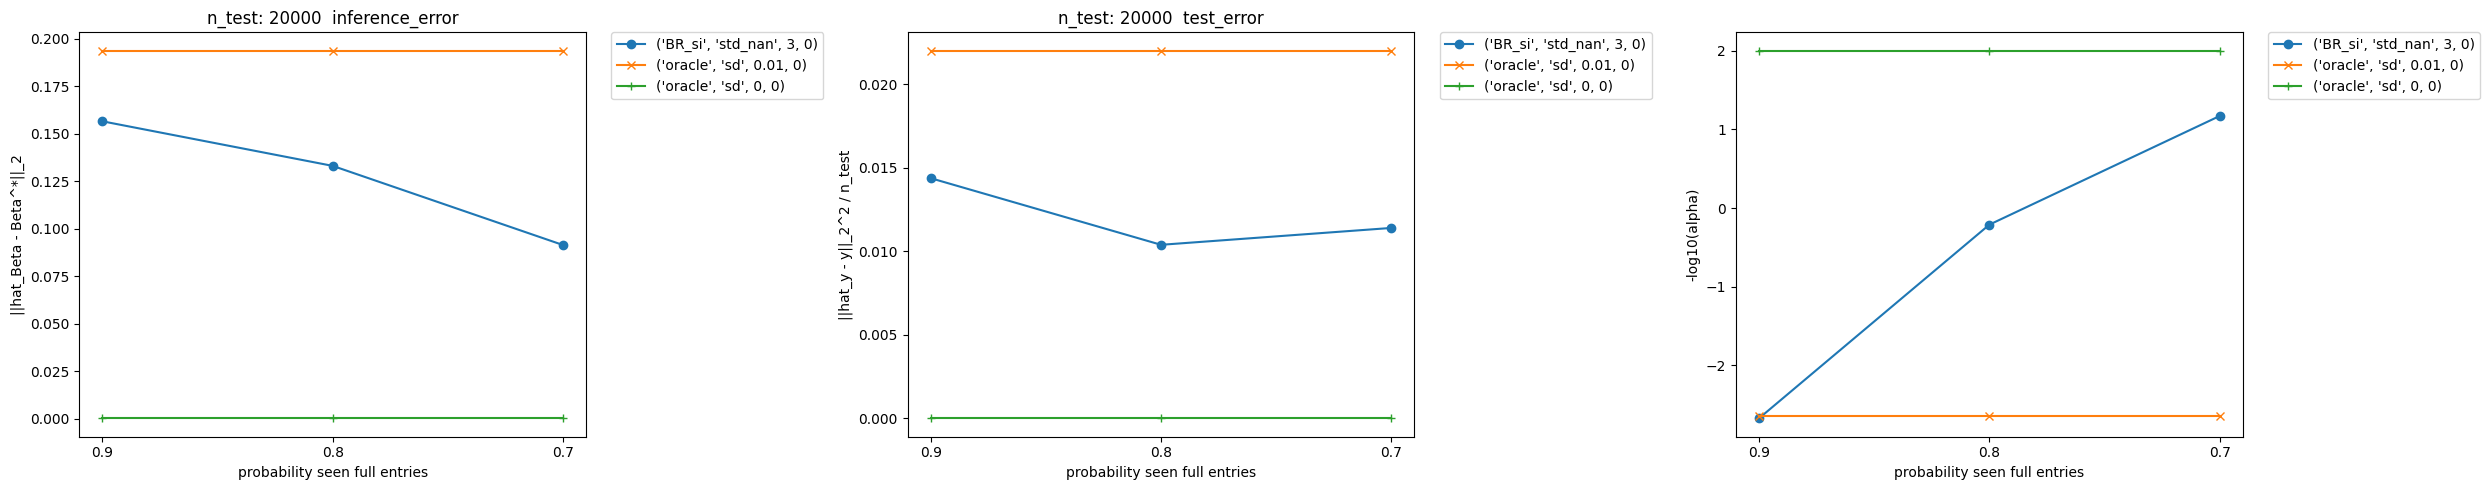

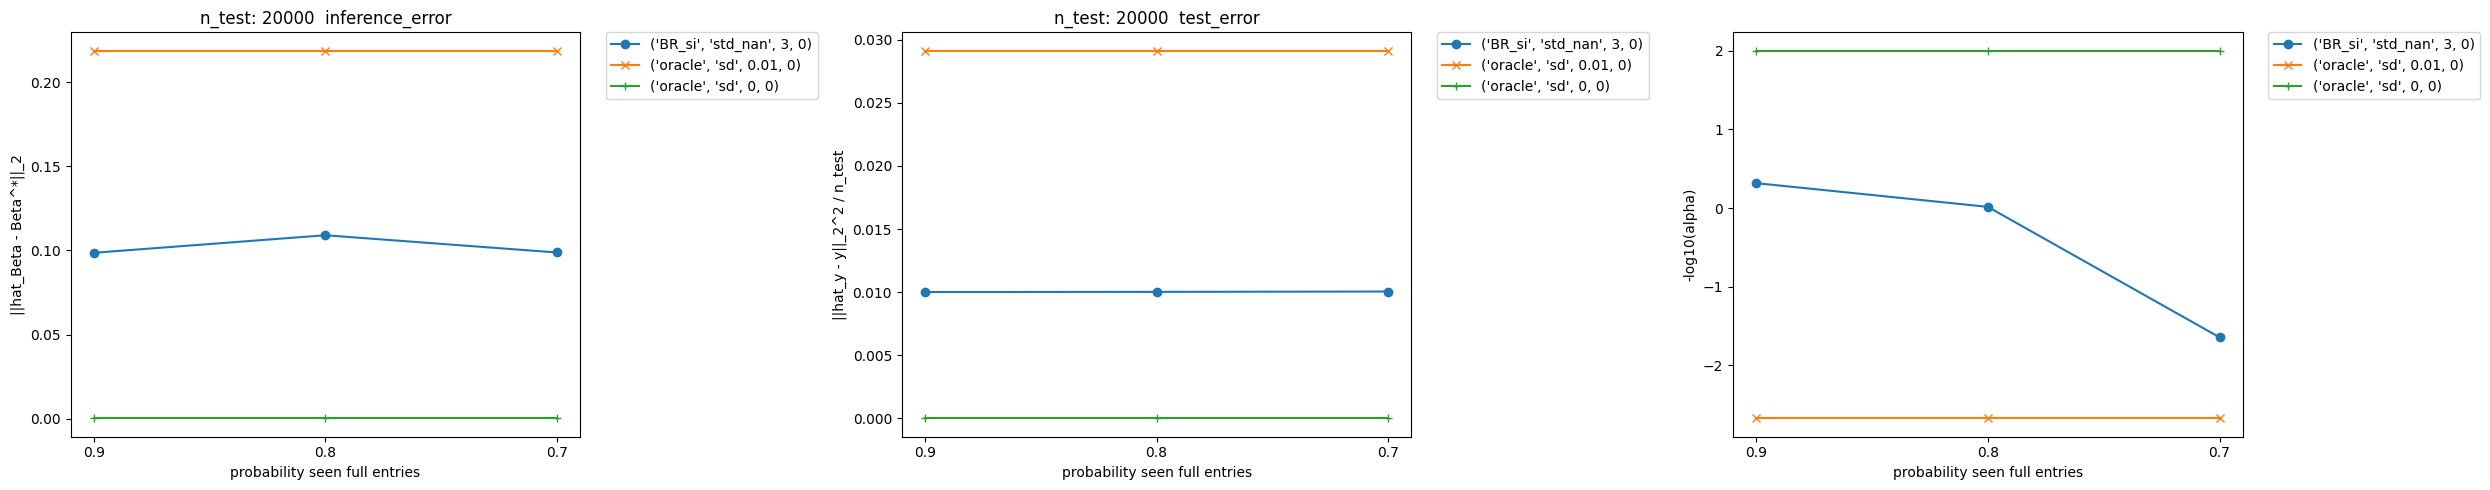

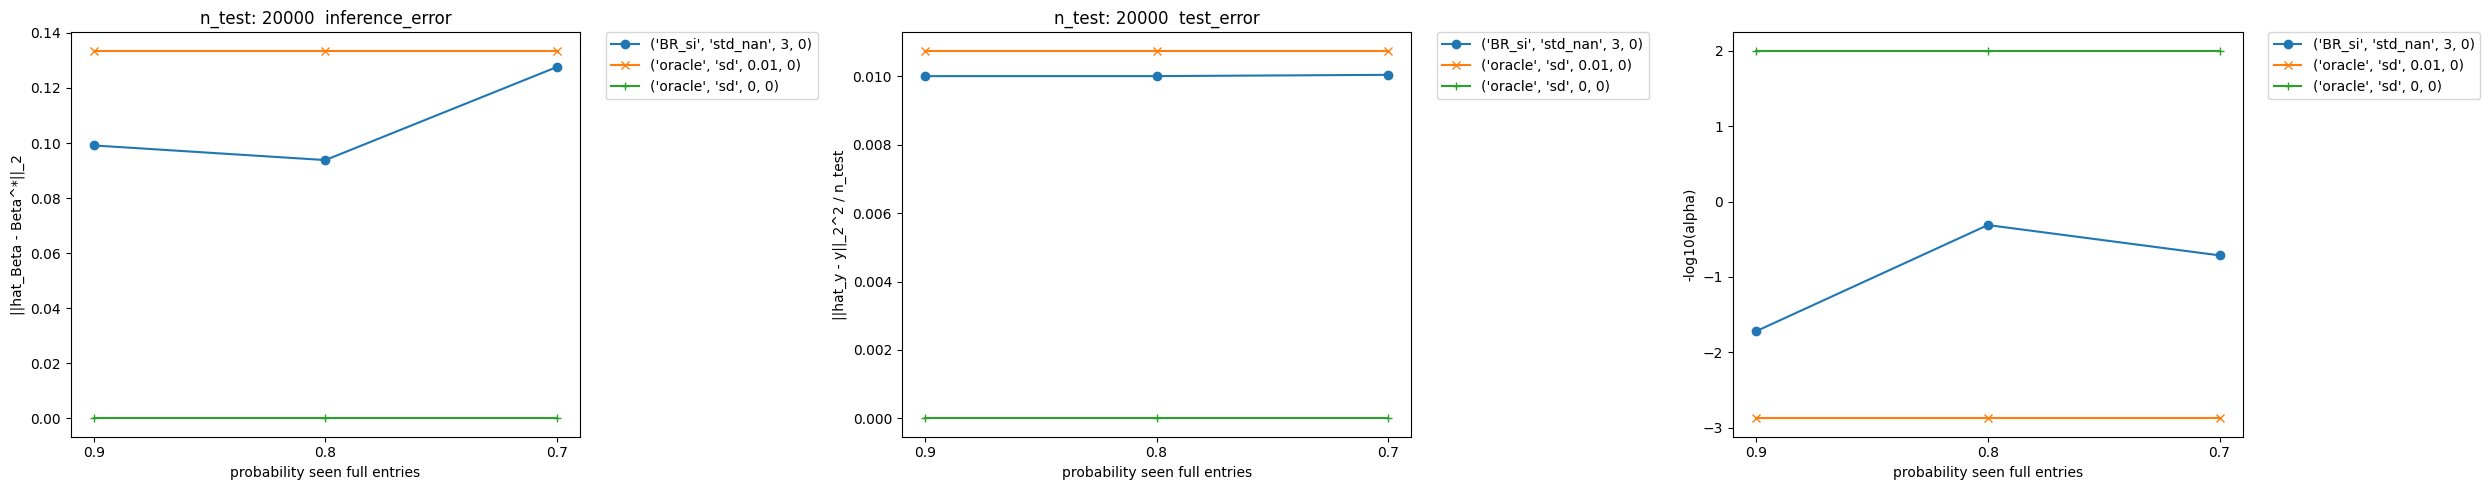

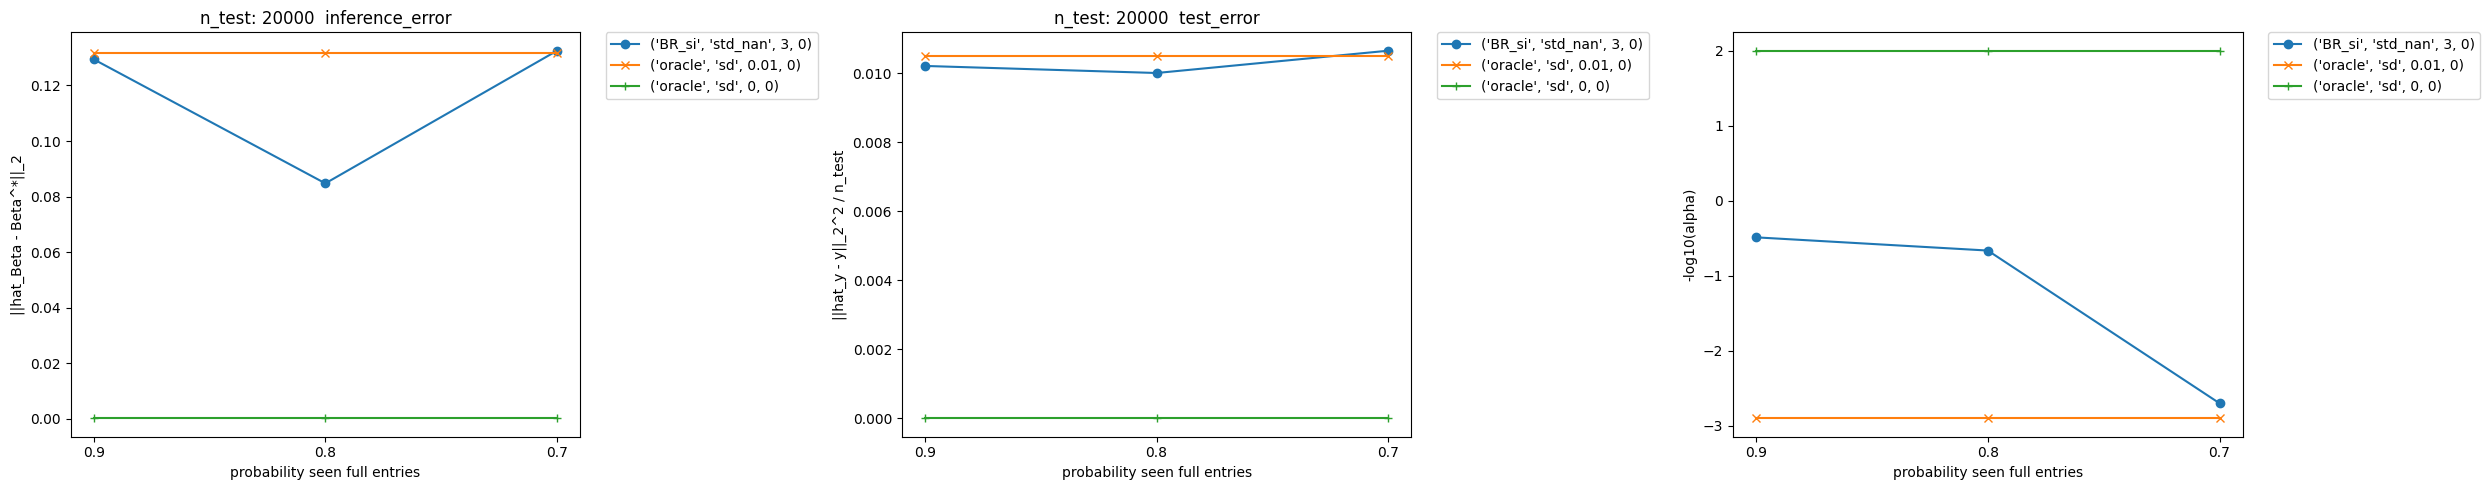

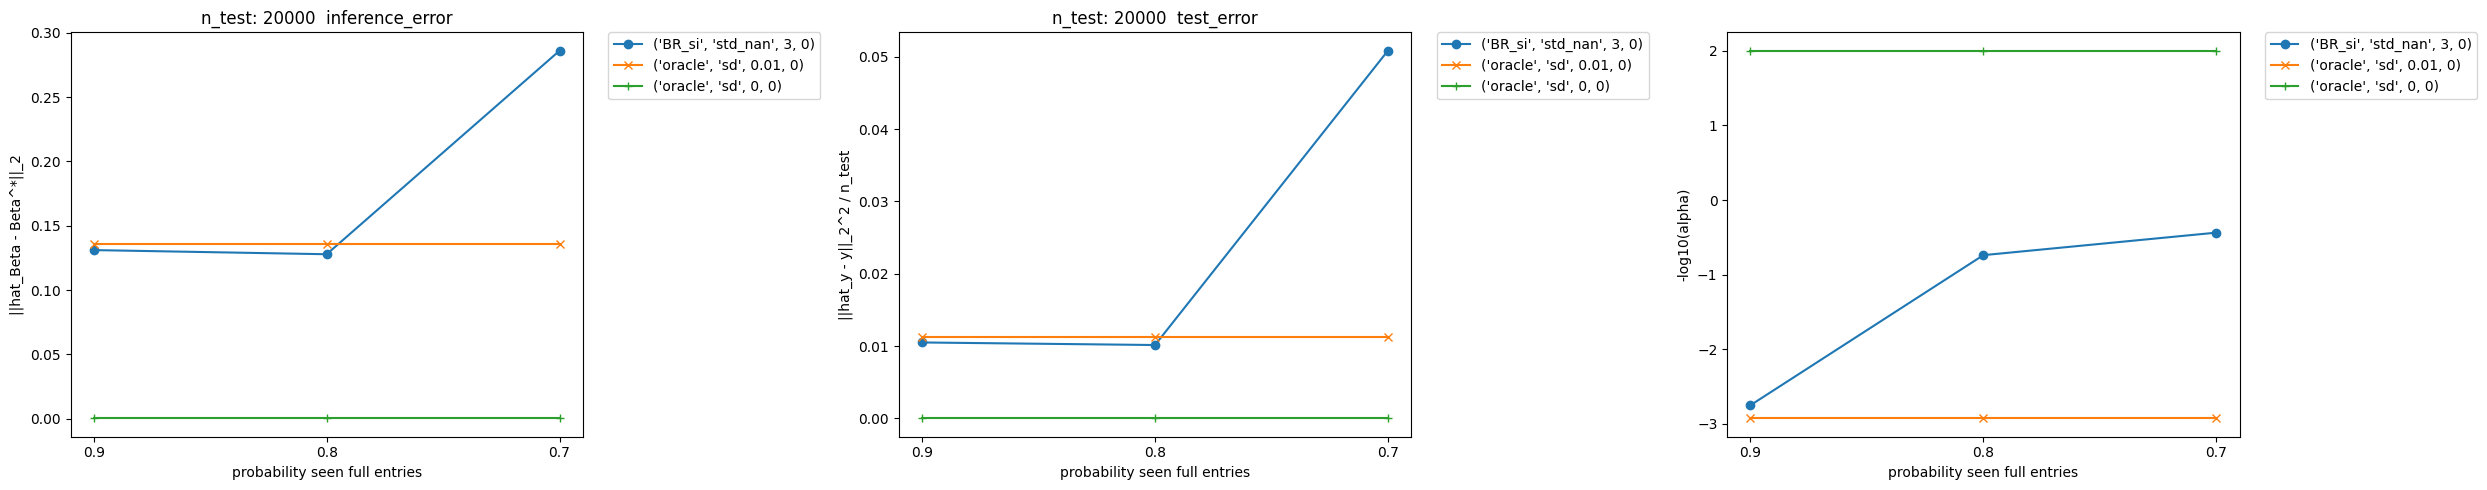

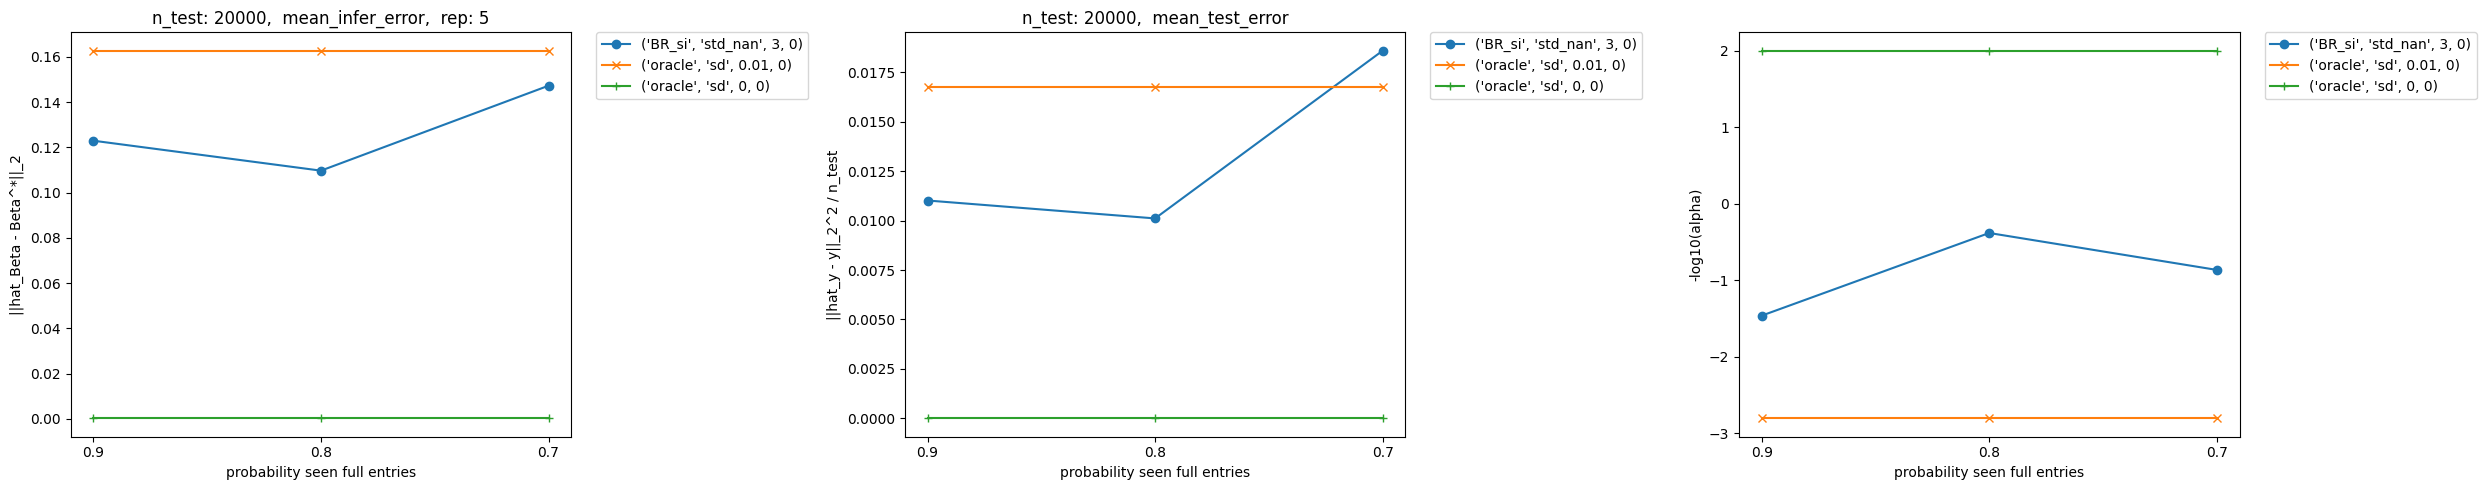

In [25]:

#info_axis = 'train'
#n_train = [400, 800, 1200, 1600, 2000]
#p_seen = make_probabilities([0.8, 0.8, 0.8, 0.8, 0.8])
#main_vec = n_train if info_axis == 'train' else p_seen
#info_x_axis = make_info_axis(main_vec, info_axis)

gen = 'fixed'
info_axis = 'p_seen'  # train or p_seen
#p_seen_both = [1, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02]
#p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
p_seen_both = [0.9, 0.8, 0.7]
#p_seen_both = [0.1]
#p_seen_both = [1, 0.9, 0.8]
length_vec = len(p_seen_both)
#n_train = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
n_train = [50] * length_vec
error_vec =  [0.001] * length_vec
p_seen = make_probabilities(p_seen_both)
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)


dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=20000,
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[1, 0.4], [0.4, 1]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = p_seen,
    err_vector = ['Gaussian_on_y', error_vec],
    plots = []#['points', 'l1_vs_coef', '1/alpha_vs_coef']
)
#dicc = dicc | {'generation':gen}
dicc = dicc | {'generation':gen, 'title_infer_error':'  inference_error', 'title_test_error':'  test_error'}
for key, value in dicc.items():
  print(key,": " , value[0])

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
mi_nbr = 5
list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing':0},
                        #{'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing':1},
                        {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0.01, 'multip_missing': 0},
                        {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 3},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'eye', 'mi_nbr': 2},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'cond_var', 'cov_strategy_within': 'sd', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 1},
                        #{'imp_method': 'mi_mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'eye', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 0, 'multip_with': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.2},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.4},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.6},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 1},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 5},
                        ]
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")

'''
nbr_exp = 2
#res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
#res[key_tuple]['best_coeff'].append(coeff_round)
#res[key_tuple]['best_score'].append(score_round)
#res[key_tuple]['best_alpha'].append(alpha_round)
res_l2 = []

rdm_seed = 4654321
np.random.seed(rdm_seed)
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)
if nbr_exp > 1:
  for k in res:
    for h in res[k]:
      res[k][h] = [res[k][h]]
  for i in range(nbr_exp-1):
    print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
    #np.random.seed(rdm_seed * (i+2))
    res_partial = run_experiments(dicc, list_methods_strategy)
    plot_res(info_x_axis, res_partial, dicc)
    print(res)
    for k in res:
      res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
      res[k]['best_score'].append(res_partial[k]['best_score'])
      res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
      #res[k]['best_coeff'].append(res_partial[k]['best_coeff
    #res.append(res['l2_dist_best_coeff_gt'])

print("final ")
print(res)
for k in res:
  print(k)
  print(np.array(res[k]['l2_dist_best_coeff_gt']))
  print(np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
  print(np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
#mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
for k, v in mean_res.items():
  print("k:   ", k)
  for s, t in v.items():
    print(s, ": ", t)
#print(np.mean(res, axis=0))
'''
nbr_exp = 5
seed = 432198
mean_res = run_multiple_experiments(nbr_exp, seed, dicc, info_x_axis)
print("PLOT OF THE MEANS")
dicc['title_infer_error'] = ',  mean_infer_error,  rep: ' + str(nbr_exp)
dicc['title_test_error'] = ',  mean_test_error'
#dicc = dicc | {'generation':gen, 'title_infer_error':'mean_infer_error, rep: ' + str(nbr_exp), 'title_mean_error':'mean_test_error'}
plot_res(info_x_axis, mean_res, dicc)

## you can see if you manage to take the index i that maximize alpha




In [8]:
'''
np.random.seed(456789)

#info_axis = 'train'
#n_train = [400, 800, 1200, 1600, 2000]
#p_seen = make_probabilities([0.8, 0.8, 0.8, 0.8, 0.8])
#main_vec = n_train if info_axis == 'train' else p_seen
#info_x_axis = make_info_axis(main_vec, info_axis)

gen = 'fixed'
info_axis = 'p_seen'  # train or p_seen
#p_seen_both = [1, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02]
#p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
#p_seen_both = [1, 0.9, 0.8]
length_vec = len(p_seen_both)
#n_train = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
n_train = [50] * length_vec
error_vec =  [1] * length_vec
p_seen = make_probabilities(p_seen_both)
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)


dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=20000,
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[1, -0.1], [-0.1, 1]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = p_seen,
    err_vector = ['Gaussian_on_y', error_vec],
)
dicc = dicc | {'generation':gen}
for key, value in dicc.items():
  print(key,": " , value[0])

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
mi_nbr = 30
list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with':1},
                        {'imp_method': 'l_d', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with':1},
                        {'imp_method': 'oracle', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with':1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 3},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'eye', 'mi_nbr': 2},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'cond_var', 'cov_strategy_within': 'sd', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 1},
                        #{'imp_method': 'mi_mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'eye', 'mi_nbr': 5},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 0, 'multip_with': 0},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 0, 'multip_with': 1},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 3, 'multip_with': 0},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 3, 'multip_with': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 5},
                        ]
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)



## you can see if you manage to take the index i that maximize alpha
'''


'\nnp.random.seed(456789)\n\n#info_axis = \'train\'\n#n_train = [400, 800, 1200, 1600, 2000]\n#p_seen = make_probabilities([0.8, 0.8, 0.8, 0.8, 0.8])\n#main_vec = n_train if info_axis == \'train\' else p_seen\n#info_x_axis = make_info_axis(main_vec, info_axis)\n\ngen = \'fixed\'\ninfo_axis = \'p_seen\'  # train or p_seen\n#p_seen_both = [1, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02]\n#p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]\np_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]\n#p_seen_both = [1, 0.9, 0.8]\nlength_vec = len(p_seen_both)\n#n_train = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]\nn_train = [50] * length_vec\nerror_vec =  [1] * length_vec\np_seen = make_probabilities(p_seen_both)\nif info_axis == \'train\':\n  main_vec = n_train\nelif info_axis == \'p_seen\':\n  main_vec = p_seen_both\nelif info_axis == \'error\':\n  main_vec = erro

In [9]:
X = np.random.randint(2, 5, size=(2, 2, 2))
print(X)

XX = np.concatenate(X)
print(XX)


Y = np.random.randint(2, 5, size=(1, 3, 2))
print(Y)

YY = np.concatenate(Y)
print(YY)


Z = np.random.randint(2, 5, size=(5, 2))
print(Z)

ZZ = np.concatenate(Z)
print(ZZ)

print("other")
s = np.random.randint(2, 4, 5)
print(s)
z = np.tile(s, reps=3)  # np.array([s] * 2)
print(z)


print("other mult")
s = np.random.randint(2, 8, size=(3, 2))
print(s)
z = np.tile(s, reps=(3, 1))  # np.array([s] * 2)
print(z)


[[[3 4]
  [3 2]]

 [[3 3]
  [4 2]]]
[[3 4]
 [3 2]
 [3 3]
 [4 2]]
[[[2 4]
  [4 4]
  [3 3]]]
[[2 4]
 [4 4]
 [3 3]]
[[2 3]
 [3 3]
 [3 3]
 [2 2]
 [2 4]]
[2 3 3 3 3 3 2 2 2 4]
other
[2 3 2 3 3]
[2 3 2 3 3 2 3 2 3 3 2 3 2 3 3]
other mult
[[5 2]
 [4 4]
 [7 2]]
[[5 2]
 [4 4]
 [7 2]
 [5 2]
 [4 4]
 [7 2]
 [5 2]
 [4 4]
 [7 2]]


In [10]:
'''
## random forest imputer
from sklearn.ensemble import RandomForestRegressor
rf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)

X_rf = single_imputation(X_nan, rf_estimator)
print(X_rf.shape)
sd_rf = np.std(X_rf, axis=0)
S_inv_rf = np.diag(1 / sd_rf)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std rf\n ", sd_rf)
fig, ax = plt.subplots(num='advtrain_linf_rf')
linfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)
estimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_rf, ax)
'''

'\n## random forest imputer\nfrom sklearn.ensemble import RandomForestRegressor\nrf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)\n\nX_rf = single_imputation(X_nan, rf_estimator)\nprint(X_rf.shape)\nsd_rf = np.std(X_rf, axis=0)\nS_inv_rf = np.diag(1 / sd_rf)\nprint("std_orig: \n", np.std(X_orig, axis=0))\nprint("std rf\n ", sd_rf)\nfig, ax = plt.subplots(num=\'advtrain_linf_rf\')\nlinfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)\nestimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)\nplot_coefs_l1norm(coefs_advtrain_linf_rf, ax)\n'

In [11]:
'''
## iterative imputer Bayesian Ridge

from sklearn.linear_model import BayesianRidge
br_estimator = BayesianRidge()

X_br = single_imputation(X_nan, br_estimator)
sd_br = np.std(X_br, axis=0)
S_inv_br = np.diag(1 / sd_br)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std  br\n ", sd_br)

fig, ax = plt.subplots(num='advtrain_linf_br')
linfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)
estimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)
alphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)
plot_coefs_l1norm(coefs_advtrain_linf_br, ax)
'''

'\n## iterative imputer Bayesian Ridge\n\nfrom sklearn.linear_model import BayesianRidge\nbr_estimator = BayesianRidge()\n\nX_br = single_imputation(X_nan, br_estimator)\nsd_br = np.std(X_br, axis=0)\nS_inv_br = np.diag(1 / sd_br)\nprint("std_orig: \n", np.std(X_orig, axis=0))\nprint("std  br\n ", sd_br)\n\nfig, ax = plt.subplots(num=\'advtrain_linf_br\')\nlinfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)\nestimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)\nplot_coefs_l1norm(coefs_advtrain_linf_br, ax)\n'

In [12]:
'''
## mean imputation
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_mean = imp_mean.fit_transform(X_nan)
sd_mean = np.std(X_mean, axis=0)
print(sd_mean)
S_inv_mean = np.diag(1 / sd_mean)

fig, ax = plt.subplots(num='advtrain_linf_mean')
linfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)
estimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mean, ax)
'''

"\n## mean imputation\nfrom sklearn.impute import SimpleImputer\n\nimp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')\nX_mean = imp_mean.fit_transform(X_nan)\nsd_mean = np.std(X_mean, axis=0)\nprint(sd_mean)\nS_inv_mean = np.diag(1 / sd_mean)\n\nfig, ax = plt.subplots(num='advtrain_linf_mean')\nlinfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)\nestimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)\nplot_coefs_l1norm(coefs_advtrain_linf_mean, ax)\n"

In [13]:
'''
# imputation elliptic

mu = np.nanmean(X_nan, axis=0)
print("means ", mu)
delta = np.mean(masks) # parameter missingness
print("delta ", delta)
X_0 = np.nan_to_num(X_nan)
print("nbr obs", X_0.shape[0])
S_ellp =  X_0.T @ X_0 / X_0.shape[0]
S_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp
print("eig cov ", np.linalg.eigvalsh(S_ellp))
X_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)
#S_inv_ellp = np.linalg.inv(S_ellp)  # other variance
sd_inv_ellp = np.std(X_ellp, axis=0)
print("sd ellp", sd_inv_ellp)

fig, ax = plt.subplots(num='advtrain_linf_ellp')
linfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_ellp, p=np.inf)
estimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)
alphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)
'''

'\n# imputation elliptic\n\nmu = np.nanmean(X_nan, axis=0)\nprint("means ", mu)\ndelta = np.mean(masks) # parameter missingness\nprint("delta ", delta)\nX_0 = np.nan_to_num(X_nan)\nprint("nbr obs", X_0.shape[0])\nS_ellp =  X_0.T @ X_0 / X_0.shape[0]\nS_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp\nprint("eig cov ", np.linalg.eigvalsh(S_ellp))\nX_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)\n#S_inv_ellp = np.linalg.inv(S_ellp)  # other variance\nsd_inv_ellp = np.std(X_ellp, axis=0)\nprint("sd ellp", sd_inv_ellp)\n\nfig, ax = plt.subplots(num=\'advtrain_linf_ellp\')\nlinfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_ellp, p=np.inf)\nestimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)\nplot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)\n'

TypeError: add_rectangles() takes 4 positional arguments but 5 were given

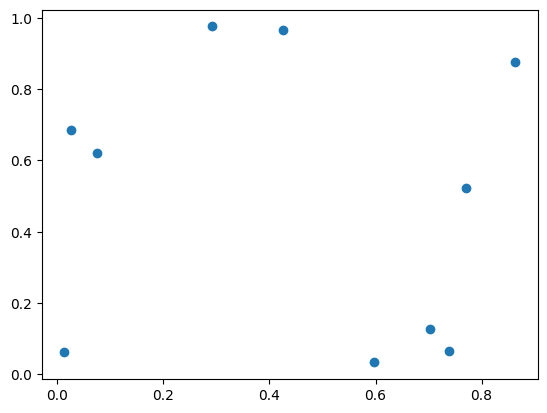

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


# Example data
x_test_rect = np.random.rand(10)
y_test_rect = np.random.rand(10)

# Plot the points
fig, ax = plt.subplots()
ax.scatter(x_test_rect, y_test_rect)

width = 0.1
height = 0.1

add_rectangles(x_test_rect, y_test_rect, width, height, ax)

# Add the rectangle to the plot


In [ ]:
# Cell for some tests

def test_clear_dataset(n, d):
  print("test clear dataset")
  X = np.random.randint(1, 3, size=(n, d))
  y = np.random.randint(1, 3, size=n)
  masks = np.random.binomial(1, 0.3, size=(n, d))
  print("X \n", X)
  print("y\n", y)
  print("masks \n", masks)
  masks[:, 0] = np.ones(n)
  masks[0, :] = np.ones(d)
  X_res, y_res, masks_res = clear_dataset(X, y, masks)
  print("X_res \n", X_res)
  print("y\n", y_res)
  print("masks \n", masks_res)
  print("test clear dataset ended successfully")

def test_generate_X():
    print("test generate_X started")
    fig, ax = plt.subplots(3, 1, figsize=(10, 8), num='advtrain_linf')
    gen = generate_X('circles', 2)
    data = gen(1000)
    print(data.shape)
    ax[0].scatter(data[:, 0], data[:, 1])
    print("test generate passed syccessfully")

def test_preparation_dataset(n, d):
      print("\ntest preparation dataset started")
      X_train = np.random.rand(n, d)
      print("X_train \n", X_train)
      mask = np.random.binomial(1, 0.5, (n, d))
      print("mask, 0 seen, 1 missing \n ", mask)
      X_masked = X_train * (1 - mask)
      print("X_masked \n", X_masked)
      X_nan_train = X_train.copy()
      X_nan_train[mask == 1] = np.nan
      print("X_nan_train \n", X_nan_train)
      X_br_train = single_imputation(X_nan_train, BayesianRidge())
      print("X_br_train\n ", X_br_train)

      print("what happens if we run single_imputation of full dataset")
      X_br_full = single_imputation(X_train, BayesianRidge())
      print("X_br_full\n ", X_br_full)
      np.testing.assert_allclose(X_train, X_br_full)  # shuold be untouched
      print("test preparation dataset ended successfully")

def test_listwise_delection(n, d):
    print("\n test list_wise delection started")
    X = np.random.rand(n, d)
    print("data\n", X)
    mask = np.random.binomial(1, 0.2, (n, d))
    print("mask \n", mask)
    X_ld = listwise_delection(X, mask)
    print("after calling function, X_ld \n", X_ld)

    print("edge cases, all missing")
    mask_1 = np.ones_like(X)  # all missing
    X1 = listwise_delection(X, mask_1)
    print("X1 \n", X1)  # should be empty
    mask_0 = np.zeros_like(X)  # all seen
    X0 = listwise_delection(X, mask_0)
    print("X0 \n", X0)
    np.testing.assert_allclose(X0, X)  # should be the original dataset

    print("one dimnsional array")
    y = np.random.rand(n)
    print("y before ", y)
    y_ld = listwise_delection(y, mask)
    print("y after ld ", y_ld)
    print("test listwise_delection passed")


test_generate_X()
test_preparation_dataset(3, 4)
test_listwise_delection(3, 4)
test_clear_dataset(6, 3)

xxx = np.random.randint(2, 5, size=(3, 3)) * 1.0
mmm = np.random.binomial(1, 0.5, size=(3, 3))
print(xxx)
print(mmm)
print(mmm == 1)
print(xxx[mmm == 1])
xxx[mmm == 1] = np.nan
print(xxx)
mask_from_xxx = np.isnan(xxx).astype(int)
print("mask from xxx \n", mask_from_xxx)


In [ ]:
# test best predictor

def test_best_predictor(n, d, nb_coeff):
  X_test = np.random.randint(1, 9, size=(n, d))
  beta_gt_test = np.random.randint(1, 7, size=d)
  y_test = X_test @ beta_gt_test
  #print("X_test \n", X_test, "\n beta_gt", beta_gt_test, "\n y_test = X_test @ beta_gt_test ", y_test)
  coeff_test = np.random.randint(1, 5, size=(d, nb_coeff))
  rdm_idx = np.random.randint(1, d+1, size=1)
  print(rdm_idx)
  #print("coeff test partial ", coeff_test[:, -1])
  rng = np.arange(nb_coeff)
  #print(rng != rdm_idx)
  coeff_test[:, rng != rdm_idx] = coeff_test[:, rng != rdm_idx] + 1000  # increase artificially the value of the other coefficient, to induce the minimum index to be rdm_idx
  #print("coeff_test \n", coeff_test)
  best_coeff, best_score = best_predictor(X_test, coeff_test, y_test)
  print("best coeff ", best_coeff)
  print("best score ", best_score)
  np.testing.assert_allclose(best_coeff, coeff_test[:,rdm_idx].squeeze())
  print("test best predictor passed")

test_best_predictor(100, 5, 20)




In [ ]:
# test train_and_plot

X_diab, y_diab = datasets.load_diabetes(return_X_y=True)
n, d = X_diab.shape
print("n:  ", n, ", d: ", d)
# Standardize data
X_diab -= X_diab.mean(axis=0)
X_diab /= X_diab.std(axis=0)

## original lasso
fig_l, ax_l = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X_diab, y_diab)
plot_coefs_l1norm(coefs_lasso, ax_l)

## Antonio's algo, 1 matrix
S_diab_eye = np.eye(X_diab.shape[1])
fig, ax_1 = plt.subplots(1, 1, num='advtrain_linf_diab')
fig, ax_2 = plt.subplots(1, 1, num='advtrain_linf_diab_2')
train_and_plot(X_diab, y_diab, S_diab_eye, [ax_1, ax_2])

## Antonio's algo, multiple diagonal matrix
#S_diab = np.eye(X_diab.shape[1])
#S_diab = np.random.randint(1, 3, size=(n, d))
#print(S_diab)
#fig, ax_5 = plt.subplots(1, 1, num='advtrain_linf_diab_5')
#fig, ax_6 = plt.subplots(1, 1, num='advtrain_linf_diab_6')
#train_and_plot(X_diab, y_diab, S_diab, [ax_5, ax_6])


## Antonio's algo, multiple matrices (same matrix stacked multiple time)
S_diab_stacked = np.array([S_diab_eye] * X_diab.shape[0])
S_diab_stacked = np.concatenate(S_diab_stacked)
fig, ax_3 = plt.subplots(1, 1, num='advtrain_linf_diab_3')
fig, ax_4 = plt.subplots(1, 1, num='advtrain_linf_diab_4')
train_and_plot(X_diab, y_diab, S_diab_stacked, [ax_3, ax_4])




In [ ]:
# test imputations

np.random.seed(45)


def test_imputations(n, d):
  X = np.random.randint(2, 5, size=(n, d)) * 1.0
  y = X @ np.random.randint(1, 3, size=d)
  m = np.random.binomial(1, 0.4, size=(n, d))  # 1 missing, 0 seen
  print("m original\n", m)
  X, y, m = clear_dataset(X, y, m)
  print(m)
  X_nan = X.copy()
  X_nan[m == 1] = np.nan

  #mask_from_xxx = np.isnan(xxx).astype(int)
  print("X\n ", X)
  print("masks \n", m)
  print("X_nan\n ", X_nan)
  methods = ['BR_si', 'mi', 'l_d']
  nbr_mi = [1, 3]
  #for method in methods:
  #  dict_info = {'imp_method': method, 'mi_nbr':nbr_mi}
  #dict_info = {'imp_method':methods, 'mi_nbr':nbr_mi}
  for method in methods:
    print("---------- method: ", method)
    if method == 'mi':
      for x in nbr_mi:
        print("-------------------- nbr mi: ", x)
        dict_info = {'imp_method':method, 'mi_nbr':x}
        #print("XNANNANAN ", X_nan)
        X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
        print(X_res, y_res, "\n", mask_res)
    else:
      dict_info = {'imp_method': method}
      X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
      print(X_res, y_res, "\n", mask_res)
    print("test imputations ended successfully")

test_imputations(6, 3)


In [ ]:
x = []
y = np.array([1, 2])
x.append(y)
x.append(y)
x.append(y)
xx = np.stack(x)
print(x)
print(xx)
print(type(xx))


import matplotlib.pyplot as plt

sizes = [100, 1000, 10000, 100000]
values = [0.8, 0.85, 0.9, 0.92]
positions = range(len(sizes))

plt.plot(positions, values, marker='o', label='Model Accuracy')  # Add label here
plt.xticks(positions, sizes)

plt.xlabel("Dataset Size (equispaced)")
plt.ylabel("Accuracy")
plt.title("Performance vs Dataset Size (equispaced x-axis)")
#plt.legend()  # Show legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()



In [ ]:

dictio = {'a':1, 'b':2, 'c':3}
vv = dictio.values()
#print(vv)
#print(vv[1])

x1 = np.array([1, 2, 3])
x2 = np.array([3, 2 ,1])
v = np.maximum(x1, x2)
print(v)


In [ ]:
m, n, d = 2, 3, 2
x_int = np.random.randint(1, 9, (m, n, d))
print(x_int)
s = np.std(x_int, axis=0)
print(s)

# manual
print("manual computation")
x = np.zeros((m, d))
for i in range(n):
  print("i -----> ", i)
  x = x_int[:, i, :]
  print("x\n", x)
  ss = np.std(x, axis=0)
  print(ss)


print("little exp on squeeze")
sss = np.random.rand(1, 3, 3)
print(sss)
print(sss.squeeze())
print(sss.squeeze())



In [ ]:
int(34.99)

xxxx = np.random.randint(2, 4, (5, 2))
print(xxxx)
xxxx[0:2, :] = 1
print(xxxx)

print("yyyy\n")
yy = []
yy.append([1, 2, 3])
yy.append([4, 5, 6])
print(yy)
print(np.stack( yy ).T)
print("\n\n")
yyy = np.random.randint(1, 10, size=(3 , 3))
print(yyy)
yyy_a = np.array([yyy] * 2)
print(yyy_a.shape)
print(np.concatenate([yyy] * 2))
#print(np.tile(yyy_a, (2, 1, 1) ))

zzz = np.zeros((2, 2))

np.sum(np.zeros((2, 2)) == zzz)

In [ ]:

def multiple_imputation1(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


Xx = np.random.randint(1, 3, (4, 4)) * 1.0
mm = np.random.binomial(1, 0.25, (4, 4))
print(Xx)
print(mm)
Xx[mm == 1] = np.nan
print(Xx)

ice = IterativeImputer(random_state=18, max_iter=50, sample_posterior=True)
ice.fit(Xx)
XxX = np.random.randint(1, 3, (2, 4)) * 1.0
mmM = np.random.binomial(1, 0.5, (2, 4))
print(XxX)
print(mmM)
XxX[mmM == 1] = np.nan
print(XxX)

print(ice.transform(XxX))
print(ice.transform(XxX))

print("new")

ls = [[[]],[[]]]
print(ls)
ls[0][0]

